# GNN applications: Genes and Pathway embeddings

There are two datasets available and 2 types of one dataset, that is:
* The graph metapathways **metapathway_kegg_genes/gene_edges.tsv**
* The list of nodes for a pathway **metapathway_kegg_genes/pathways.tsv**
* The expression matrices normalized for:
  * Controls patients **locicero_brca_normalizzato\locicero_brca_data_norm_2.txt**
  * Tumor patients **locicero_brca_tumor\locicero_brca_data_tumor_zscores.txt**

Both of the patients are normalized with a z-score method, there is also another normalization but better results are expected with z-scores.

In [1]:
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model,Input

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn import preprocessing,model_selection

from collections import defaultdict

from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

The library used are **stellargraph** for using the GNN methods, and **tensorflow** to train the models and find the best parameters for the objective function defined in the documentation.

In [2]:
def load_my_data():
    #controlsDK = pd.read_csv('controls_counts.tsv', sep='\t', header=0).dropna()
    #z_score normalized data, the other espression matrices are normalized with another method
    controlsDK = pd.read_csv('locicero_brca_normalizzato/locicero_brca_data_norm_2.tsv', sep='\t', header=0).dropna()
    controlsDK.index = controlsDK.index.astype(int)
    controlsDK = controlsDK.sort_index()
    tumorDK = pd.read_csv('locicero_brca_tumor/locicero_brca_data_tumor_zscores.txt', sep='\t', header=0).dropna()
    tumorDK.index = tumorDK.index.astype(int)
    tumorDK = tumorDK.sort_index()
    tmp = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0)
    # creating adjacency list
    def add_edges(currentDict,N,M):
        N_set = set()
        if str(N) in currentDict:
            N_set = currentDict[str(N)]
        N_set.add(str(M))
        currentDict[str(N)] = N_set
    
    outAdjacencyListMetapathways = defaultdict(set)
    inAdjacencyListMetapathways = defaultdict(set)
    for index, row in tmp.iterrows():
        add_edges(outAdjacencyListMetapathways,row["start"],row["end"])
        add_edges(inAdjacencyListMetapathways,row["end"],row["start"])
        
    # controls with features
    boolGenesWithFeatureSources = tmp["start"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeatureTargets = tmp["end"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeature = boolGenesWithFeatureSources & boolGenesWithFeatureTargets

    # tumors with features
    boolGenesTumorWithFeatureSources = tmp["start"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeatureTargets = tmp["end"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeature = boolGenesTumorWithFeatureSources & boolGenesTumorWithFeatureTargets

    #genesWithNoFeatures = [100653049, 9103, 2831, 100528032, 100132285, 3810, 3806, 3808,390441, 3118, 3126, 3125, 390271, 26595, 81399, 432355, 100996746, 504190, 504191, 140, 504189, 729759, 100532736,107080638, 414062, 102723407, 6019, 3803, 107181291, 102723555, 102723532, 107987545, 102800317, 100505767, 341568, 112268384, 100533105, 106821730, 388372, 105369274, 100271849, 57292, 390432]
    tmpGeneEdges = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0).rename(columns={'start': 'source', 'end': 'target'}) 
    #geneEdgesWithNoFeatures = pd.concat(
    #    [geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['source'].isin(genesWithNoFeatures)], 
    #     geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['target'].isin(genesWithNoFeatures)]]
    #     )
    #geneEdgesWithNoFeatures = geneEdgesWithNoFeatures.drop_duplicates()
    geneEdgesWithNoFeatures = tmpGeneEdges[~boolGenesWithFeature]
    geneEdgesWithNoFeaturesTumor = tmpGeneEdges[~boolGenesTumorWithFeature]

    # indexes of control genes with features and not
    indexesGenesWithFeatures = controlsDK.index
    indexesGenesWithNoFeatures = pd.concat([ geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["source"].isin(controlsDK.index)]["source"] , geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["target"].isin(controlsDK.index)]["target"] ]).drop_duplicates()


    # indexes of tumor genes with features and not
    indexesGenesTumorWithFeatures = tumorDK.index
    indexesGenesTumorWithNoFeatures = pd.concat([ geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["source"].isin(tumorDK.index)]["source"] , geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["target"].isin(tumorDK.index)]["target"] ]).drop_duplicates()

    #filtering genes with no features
    #geneEdges = geneEdges[~geneEdges['source'].isin(genesWithNoFeatures)]
    #geneEdges = geneEdges[~geneEdges['target'].isin(genesWithNoFeatures)]
    geneEdges = tmpGeneEdges[boolGenesWithFeature]
    geneEdgesTumor = tmpGeneEdges[boolGenesTumorWithFeature]
    pathways = pd.read_csv('metapathway_kegg_genes/pathways.tsv', sep='\t', header=0)
    return inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK, geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexesGenesWithFeatures,indexesGenesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures, pathways

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# TODO
Taking into account genes with no features in the expression matrices(the one dropped because some values were NA), I have divided them for the two datasets of patients, but an hybrid approach could be better if we use the same model, because I have in mind to use two different models for controls and tumor, but a better approach could be to take the full expression matrix(or the union of the expressed genes with features) and complete the genes that have been dropped(that is by controlling the specific values before dropping the NA, or **substituting the NA with some value** (that could be 0, a random value taken from the distribution of the defined gene expression for the row, the expression distribution that is)). 

When sampling the tumor expressions dataset, the dropped rows in the load step should be done only on the selected columns since some of them were dropped, additionally we could totally drop columns and not rows where the values are N.A.

In [4]:
inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK,geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexGeneEdgesWithFeatures,indexGeneEdgesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures,pathways = load_my_data()

This variables are the following:
- inAdjacencyListMetapathways is used to remember all the predecessor edges(incoming) for the nodes
- inAdjacencyListMetapathways is used to remember all the antecedent edges(outgoing) for the nodes
- controlsDK is the expression matrix for the controls patients
- tumorDK is the expression matrix for the tumor patients
- geneEdges are the edges in the graph for the controls patients(subgraph with only the genes that are present in controls)
- geneEdgesTumor are the edges in the graph for the tumor patients(subgraph with only the genes that are present in tumors)
- geneEdgesWithNoFeatures are the edges in the graph that have no features for the controls patients(subgraph with only the genes that are not present in controls)
- geneEdgesWithNoFeaturesTumor are the edges in the graph that have no features for the tumor patients(subgraph with only the genes that are not present in tumors)
- indexGeneEdgesWithFeatures row number for genes in controls with features
- indexGeneEdgesWithNoFeatures row number for genes in controls with NA features
- indexesGenesTumorWithFeatures ""
- indexesGenesTumorWithNoFeatures ""
- **pathways** are the list of genes for every pathway 

In [5]:
annotationTumors = pd.read_csv('brca_clinical_stagemod.txt', sep='\t', header=0) #with NA values for subtype
annotationTumors

ID SUBTYPE AJCC_PATHOLOGIC_TUMOR_STAGE
0     TCGA-3C-AAAU    LumA                           X
1     TCGA-3C-AALI    Her2                          II
2     TCGA-3C-AALJ    LumB                          II
3     TCGA-3C-AALK    LumA                           I
4     TCGA-4H-AAAK    LumA                         III
...            ...     ...                         ...
1079  TCGA-WT-AB44    LumA                           I
1080  TCGA-XX-A899    LumA                         III
1081  TCGA-XX-A89A    LumA                          II
1082  TCGA-Z7-A8R5    LumA                         III
1083  TCGA-Z7-A8R6    LumB                           I

[1084 rows x 3 columns]

In [6]:
subtypeAnnotationLists = annotationTumors.groupby('SUBTYPE')['ID'].apply(list)
tumorStageAnnotationLists = annotationTumors.groupby('AJCC_PATHOLOGIC_TUMOR_STAGE')['ID'].apply(list)
subtypeAnnotationLists

SUBTYPE
Basal     [TCGA-A1-A0SK, TCGA-A1-A0SO, TCGA-A1-A0SP, TCG...
Her2      [TCGA-3C-AALI, TCGA-A2-A04W, TCGA-A2-A04X, TCG...
LumA      [TCGA-3C-AAAU, TCGA-3C-AALK, TCGA-4H-AAAK, TCG...
LumB      [TCGA-3C-AALJ, TCGA-5T-A9QA, TCGA-A1-A0SI, TCG...
Normal    [TCGA-A1-A0SB, TCGA-A2-A0CL, TCGA-A2-A0YK, TCG...
Name: ID, dtype: object

In [7]:
tumorStageAnnotationLists

AJCC_PATHOLOGIC_TUMOR_STAGE
I      [TCGA-3C-AALK, TCGA-A1-A0SB, TCGA-A1-A0SE, TCG...
II     [TCGA-3C-AALI, TCGA-3C-AALJ, TCGA-5L-AAT0, TCG...
III    [TCGA-4H-AAAK, TCGA-A1-A0SJ, TCGA-A2-A04P, TCG...
IV     [TCGA-A2-A0CS, TCGA-A2-A0SV, TCGA-A2-A0SW, TCG...
X      [TCGA-3C-AAAU, TCGA-A8-A07E, TCGA-A8-A099, TCG...
Name: ID, dtype: object

## tumor subtypes and stages datasets

In [8]:
tumorDKwithAnnotation = tumorDK.copy()
tumorDK = tumorDK.drop(["Hugo_Symbol","Entrez_Gene_Id"],axis=1)

In [9]:
#subtypes
basalExprMatrix = tumorDK.filter(subtypeAnnotationLists[0])
her2ExprMatrix = tumorDK.filter(subtypeAnnotationLists[1])
lumAExprMatrix = tumorDK.filter(subtypeAnnotationLists[2])
lumBExprMatrix = tumorDK.filter(subtypeAnnotationLists[3])
normalExprMatrix = tumorDK.filter(subtypeAnnotationLists[4])
#stage
stageIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[0])
stageIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[1])
stageIIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[2])
stageIVExprMatrix = tumorDK.filter(tumorStageAnnotationLists[3])
stageXExprMatrix = tumorDK.filter(tumorStageAnnotationLists[4])

**sampling columns because there are too many features and GPU memory is not enouth, probably leaving aside this in the future.** 
REDACTED the division is done on subtypes and stages, this part is not useful now.

In [10]:
tumorDKfull = tumorDK.copy()
tumorDK = tumorDK.sample(frac=0.36, axis='columns', random_state=2)

In [6]:
tumorDK.head()

TCGA-A2-A1FX-01  TCGA-D8-A1XB-01  TCGA-BH-A0E1-01  TCGA-AQ-A04J-01  \
2           -0.5772           0.0209          -0.7586           2.1600   
3            2.6653           0.6561           1.1721           4.9628   
7           -2.1170          -2.1170          -2.1170          -1.2330   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741          -1.9741          -1.9741          -1.0737   

    TCGA-BH-A0E9-01  TCGA-C8-A133-01  TCGA-B6-A0IG-01  TCGA-LL-A8F5-01  \
2            1.1307          -3.1855           0.5628          -0.3130   
3           -0.0738          -1.3790           2.4804           0.9024   
7           -0.4007          -2.1170          -0.5807          -2.1170   
8           -4.3428          -4.3428          -4.3428          21.3320   
10          -1.9741          -1.9741          -1.9741          -1.9741   

    TCGA-E2-A14Q-01  TCGA-AR-A2LQ-01  ...  TCGA-A2-A0YI-01  TCGA-A2-A4S1-01  \
2            0.2152           0.3056  ...           0.8890          -1.4533   
3            0.7318          -0.2345  ...          -2.9581          -3.1707   
7           -2.1170          -2.1170  ...           0.8095          -2.1170   
8           -4.3428          -4.3428  ...          -4.3428          -4.3428   
10          -1.9741          -1.9741  ...          -1.9741           7.1459   

    TCGA-A8-A07B-01  TCGA-AC-A5XS-01  TCGA-GM-A5PV-01  TCGA-A1-A0SI-01  \
2            2.8468           1.1668           0.6725          -0.7789   
3            3.2360           2.7485           3.1355          -1.6424   
7           -2.1170          -2.1170          -2.1170          -1.2897   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741           3.6795          -0.8834          -1.1315   

    TCGA-AC-A2BK-01  TCGA-OL-A5DA-01  TCGA-AR-A254-01  TCGA-B6-A0I9-01  
2            1.3228           0.5238           1.4049           1.7294  
3            4.9777           2.2812           1.2282           2.0500  
7           -2.1170          -0.1780          -0.6475          -2.1170  
8           -4.3428          -4.3428          -4.3428          -4.3428  
10          -1.9741           0.6688          -1.1408          -1.0705  

[5 rows x 390 columns]

In [7]:
tumorDKwithAnnotation.head()

Hugo_Symbol  Entrez_Gene_Id  TCGA-3C-AAAU-01  TCGA-3C-AALI-01  \
2     UBE2Q2P2       100134869           1.4054           1.8883   
3      HMGB1P1           10357          -2.6318          -1.1750   
7     RNU12-2P           26823          -2.1170           0.2431   
8        SSX9P          280660          -4.3428          -0.2931   
10       EZHIP          340602           1.2983          14.2840   

    TCGA-3C-AALJ-01  TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
2            0.8671           1.1569           1.5834           1.4882   
3            2.8280           2.4738          -0.2282           1.3096   
7           -2.1170          -1.0068          -0.9801          -2.1170   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741          -1.9741          -0.8161          -1.9741   

    TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  ...  TCGA-UL-AAZ6-01  TCGA-UU-A93S-01  \
2            0.8268           1.5793  ...           1.5769           1.1282   
3            1.0050           1.4029  ...           2.1756           2.1944   
7           -0.7680          -0.9244  ...          -2.1170          -2.1170   
8           -4.3428          -4.3428  ...           1.1306          -4.3428   
10          -1.9741           0.1242  ...          -1.9741           8.4276   

    TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  TCGA-WT-AB44-01  \
2           -0.7352           1.5768           0.2812          -0.6605   
3           -5.3776           1.8957          -2.4922          -3.6798   
7           -0.5783          -0.8715          -2.1170           3.0903   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741           0.2060           3.7291          -0.0279   

    TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  TCGA-Z7-A8R6-01  
2            2.2363           2.6390           0.5014           2.4780  
3            2.2552          -1.5958          -0.1787           3.2450  
7            2.1266          -0.8763          -0.6152          -1.1594  
8           -4.3428          -4.3428          -4.3428          -4.3428  
10           2.3484           7.5525          -1.9741          -0.9987  

[5 rows x 1084 columns]

In [8]:
geneEdgesWithNoFeatures.head()

source  target  weight
0     3640   51289       1
1     3640  122042       1
2     3640  339403       1
30  121275    2788       1
31  121275    2774       1

In [8]:
geneEdgesWithNoFeaturesTumor.head()

source  target  weight
0    3640   51289       1
1    3640  122042       1
2    3640  339403       1
3    3640   59350       1
4  284217    3680       1

In [9]:
geneEdgesWithNoFeatures.count()

source    8963
target    8963
weight    8963
dtype: int64

In [10]:
geneEdgesWithNoFeaturesTumor.count()

source    11646
target    11646
weight    11646
dtype: int64

In [11]:
geneEdges.count()

source    19947
target    19947
weight    19947
dtype: int64

In [12]:
geneEdgesTumor.count()

source    17264
target    17264
weight    17264
dtype: int64

In [13]:
controlsDK.head()

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                       2.439591                      1.004656   
2                      11.117521                     10.700190   
9                       2.615676                      2.953189   
10                     -3.253567                     -2.009078   
12                      9.974828                      9.649463   

    TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                       1.599506                      1.239184   
2                       9.912663                     10.474133   
9                       1.625789                      2.475094   
10                      2.278639                     -4.987067   
12                      7.164353                      6.765174   

    TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                       2.378383                      0.943205   
2                      10.027498                     10.540336   
9                       3.611098                      4.456799   
10                     -1.441223                     -3.628251   
12                      8.275051                      8.173861   

    TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                       1.152047                     -0.639025   
2                      11.246892                     10.206510   
9                       2.610675                      0.141662   
10                     -3.850246                     -5.924427   
12                      4.038497                      2.539097   

    TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                       1.853060                      2.006845  ...   
2                      10.568919                     11.340917  ...   
9                       4.567000                      1.842379  ...   
10                     -2.509816                     -3.570403  ...   
12                      9.262608                      4.256145  ...   

    TCGA-BH-A0B5-11A-23R-A12P-07  TCGA-BH-A1F8-11B-21R-A13Q-07  \
1                      -0.991596                      1.574434   
2                      10.605164                     10.596202   
9                       2.162604                      2.803166   
10                     -2.648709                     -2.123392   
12                      2.984007                      8.878554   

    TCGA-A7-A0CH-11A-32R-A089-07  TCGA-BH-A1FM-11B-23R-A13Q-07  \
1                       2.381900                      1.606963   
2                      10.600770                     10.643696   
9                       6.262478                      2.162206   
10                      0.647096                     -2.375228   
12                      8.679858                      7.475653   

    TCGA-BH-A18K-11A-13R-A12D-07  TCGA-E9-A1NF-11A-73R-A14D-07  \
1                       1.776588                      0.497882   
2                      10.941248                     10.856412   
9                       2.174944                      1.894063   
10                     -3.034509                     -4.754595   
12                      8.017009                      2.971056   

    TCGA-BH-A18U-11A-23R-A12D-07  TCGA-BH-A208-11A-51R-A157-07  \
1                       1.806789                      1.720538   
2                      10.177214                      9.934674   
9                       4.200827                      1.692294   
10                     -0.293221                     -4.750650   
12                      9.331412                      8.747028   

    TCGA-BH-A1EW-11B-33R-A137-07  TCGA-BH-A204-11A-53R-A157-07  
1                       1.908005                      0.623442  
2                       9.725920                     11.157303  
9                       7.640509                      2.870837  
10                     -1.192199                     -2.146698  
12                      8.771013                      7.260385  

[5 rows x 

In [14]:
tumorDK.head()

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2            1.4054           1.8883           0.8671           1.1569   
3           -2.6318          -1.1750           2.8280           2.4738   
7           -2.1170           0.2431          -2.1170          -1.0068   
8           -4.3428          -0.2931          -4.3428          -4.3428   
10           1.2983          14.2840          -1.9741          -1.9741   

    TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2            1.5834           1.4882           0.8268           1.5793   
3           -0.2282           1.3096           1.0050           1.4029   
7           -0.9801          -2.1170          -0.7680          -0.9244   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -0.8161          -1.9741          -1.9741           0.1242   

    TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-UL-AAZ6-01  TCGA-UU-A93S-01  \
2            1.1918          -0.2327  ...           1.5769           1.1282   
3           -1.9085           2.7901  ...           2.1756           2.1944   
7           -1.2006          -2.1170  ...          -2.1170          -2.1170   
8           -4.3428          -4.3428  ...           1.1306          -4.3428   
10          -0.3155          -1.9741  ...          -1.9741           8.4276   

    TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  TCGA-WT-AB44-01  \
2           -0.7352           1.5768           0.2812          -0.6605   
3           -5.3776           1.8957          -2.4922          -3.6798   
7           -0.5783          -0.8715          -2.1170           3.0903   
8           -4.3428          -4.3428          -4.3428          -4.3428   
10          -1.9741           0.2060           3.7291          -0.0279   

    TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  TCGA-Z7-A8R6-01  
2            2.2363           2.6390           0.5014           2.4780  
3            2.2552          -1.5958          -0.1787           3.2450  
7            2.1266          -0.8763          -0.6152          -1.1594  
8           -4.3428          -4.3428          -4.3428          -4.3428  
10           2.3484           7.5525          -1.9741          -0.9987  

[5 rows x 1082 columns]

<AxesSubplot:ylabel='Density'>

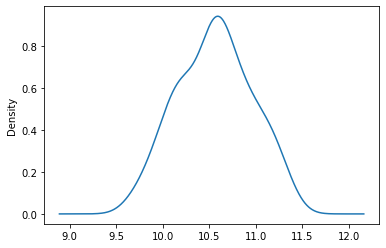

In [15]:
controlsDK.iloc[1].plot.kde()

In [16]:
pathways.head()

pathway_id                                  pathway_name  \
0  path:hsa00190                     Oxidative phosphorylation   
1  path:hsa00072    Synthesis and degradation of ketone bodies   
2  path:hsa01040       Biosynthesis of unsaturated fatty acids   
3  path:hsa04672  Intestinal immune network for IgA production   
4  path:hsa03460                        Fanconi anemia pathway   

                                               nodes  
0  64077;5464;245972;245973;479;513;514;515;516;5...  
1    64064;38;39;3155;56898;54511;622;3158;3157;5019  
2  641371;79966;6319;570;9415;3992;10965;122970;1...  
3  4055;8174;959;8741;3600;23308;102723407;6370;5...  
4  3280;378708;55120;672;84126;675;2189;83990;229...

# Preliminary definitions

In [21]:
@tf.function
def difference_of_edge_genes_embeddingGCN(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[0][edges[0]]
    gene2 = y_pred[0][edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

tfControls = tf.constant(controlsDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)

In [22]:
## TESTING the computation of c
def testC(gene1,gene2,inList,outList):
    source1AdjSet = outList[str(gene1)]
    source2AdjSet = outList[str(gene2)]
    source1PredSet = inList[str(gene1)]
    source2PredSet = inList[str(gene2)]
    #c = (len(source1AdjSet) + len(source1PredSet) + len(source2AdjSet) + len(source2PredSet) -
    #     (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) ))) 
    #c = ( (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) )) + 
         #abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) )
    c = (len(source1AdjSet.intersection(source2AdjSet)) + len(source1PredSet.intersection(source2PredSet) ))/(abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) + 1.0 ) +0.01
    return c
testC(3640,6013,inAdjacencyListMetapathways,outAdjacencyListMetapathways)

4.01

In [23]:
def precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,divider):
    constantsList = []
    for i in range(0,tensorEdges.shape[0]):
        c = testC(tensorEdges[i][0].numpy(),
                tensorEdges[i][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways) / divider
        constantsList.append(c)
    return constantsList,tf.constant(constantsList,tf.float32)

In [24]:

@tf.function( experimental_relax_shapes=True)
def difference_of_genes_embedding_weightedGCN(node1,node2,y_pred,c):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    return c*tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)


@tf.function
def difference_of_genes_embeddingGCN(node1,node2,y_pred):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    tmp = tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return tmp

# loss = tf.constant(0,tf.float32)
# for row in range(0,tensorEdgesTest.shape[0]):
#     c = testC(tensorEdges[row][0].numpy(),
#               tensorEdges[row][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways)
#     loss = loss + difference_of_genes_embedding_weighted(tensorEdgesTest[row][0].numpy(),tensorEdgesTest[row][0].numpy(),tfControls,c)
# loss

The loss function used to train the GCN and the GRAPHSAGE models is the following:

$\mathcal{L}=\sum\limits_{(x,y)\in E}c(x,y)||z_x - z_y||_2$

where $z_u$ is the embedding for gene _u_

The weight for every edge is defined in the following two ways:

- $c(x,y)=\frac{|K_v|+|K_u|+|J_v|+|J_u|-(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$ 
- $c(x,y)=\frac{abs(|K_v|-|K_u|)+abs(|J_v|-|J_u|)+(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$

Where $K_i$ is the set of the predecessors of i (in edges), while $J_i$ are the successors of i (out edges).

The second weight definition takes into account not only the neighborhood of the two nodes(with the union of the two sets) but also the structure of the nodes(how many predecessors and how many successors), so we will be using that one.

 **TODO** improve the model and build a more performant loss function.

In [25]:

    
@tf.function
def genes_loss(y_true, y_pred, edges):
    loss = tf.constant(0, tf.float32)
    #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
    for row in edges:
        loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
    return loss
    #return tf.reduce_sum(partials)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
        return loss
    return loss_out


def genes_loss_with_closure_weighted(edges,inAdjacencyListMetapathways,outAdjacencyListMetapathways):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in range(0,edges.shape[0]):
            c = testC(edges[row][0],edges[row][1],inAdjacencyListMetapathways,outAdjacencyListMetapathways)
            loss = loss + difference_of_edge_genes_embedding_weightedGCN(edges[row],y_pred,c)
        return loss
    return loss_out


def optimized_loss(tensorEdgesTest,tfControls,constantTensor):
    test1 = tf.map_fn(lambda edge:difference_of_genes_embedding(edge[0],edge[1],tfControls),tensorEdgesTest,fn_output_signature=tf.float32)
    test2 = tf.math.multiply(test1,constantTensor) 
    return tf.reduce_sum(test2 )

def optimized_loss(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred):
        test1 = tf.map_fn(lambda edge:difference_of_genes_embeddingGCN(edge[0],edge[1],y_pred),tensorEdgesTest,fn_output_signature=tf.float32)
        test2 = tf.math.multiply(test1,constantTensor) 
        return tf.reduce_sum(test2 )
    return loss_out
#optimized_loss(tensorEdgesTest,tfControls,constantTensor)
        
    
#genes_loss(0,tfControls,tensorEdgesTest)

#genes_loss_with_closure(tensorEdgesTest)(0,tfControls)

#genes_loss_with_closure_weighted(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways)(0,tfControls)

In [26]:
@tf.function
def difference_of_edge_genes_embeddingGRAPHSAGE(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[edges[0]]
    gene2 = y_pred[edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGRAPHSAGE(row,y_pred)
        return loss
    return loss_out

#@tf.function
def testLoss(edge):
    def loss_out(y_true, y_pred):
        gene1 = y_pred[edge[0]]
        gene2 = y_pred[edge[1]]
        return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return loss_out

def optimized_lossGNN(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred): 
        return tf.reduce_sum(tf.math.multiply(tf.map_fn(lambda edge:difference_of_edge_genes_embeddingGRAPHSAGE(edge,y_pred),tensorEdgesTest,fn_output_signature=tf.float32),constantTensor) )
    return loss_out



#test_gen = generator.flow(test_subjects.index, test_subjects)


# Gene embeddings for controls 

In [27]:
graphWithFeatures = sg.StellarGraph(controlsDK ,geneEdges )
directedGraph = sg.StellarDiGraph(controlsDK ,geneEdges)
print(graphWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 17129, Edges: 19947

 Node types:
  default: [17129]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [19947]
        Weights: range=[-1, 1], mean=0.629318, std=0.777168
        Features: none


In [16]:
train_subjects, test_subjects = model_selection.train_test_split(
    controlsDK, train_size=int(controlsDK.shape[0] / 6.0 *5), test_size=None
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=int(test_subjects.shape[0] / 5.0 *2), test_size=None
)

In [17]:
generator = FullBatchNodeGenerator(graphWithFeatures, method="gcn")

Using GCN (local pooling) filters...


In [18]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#test_gen = generator.flow(test_subjects.index, test_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
#no test or validation set
train_gen = generator.flow(controlsDK.index,controlsDK)

Embeddings generated have the same number of features as the number of patients

In [19]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [20]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [21]:
#predictions = layers.Dense(units=train_subjects.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(controlsDK.shape[1], kernel_initializer='normal')(x_out)

In [28]:
indexOfGenes = dict()

for i in range(0,len(controlsDK.index)):
    indexOfGenes[controlsDK.index[i]] = i

tensorEdges = tf.constant(geneEdges,tf.int32)
tensorEdgesTest = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenes[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdges)  # take only edges with no weight
#tensorEdgesTest

In [23]:
inAdjacencyListMetapathways["51289"]

{'10022', '117579', '3640', '6013', '6019'}

In [63]:
@tf.function
def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
testPairs = combine(tf.constant(list(controlsDK.index)),tf.constant(list(controlsDK.index)))

In [31]:
testPairsList = tf.split(testPairs,2447,axis=0)
testPairsList[0]

<tf.Tensor: shape=(119903, 2), dtype=int32, numpy=
array([[        1,         1],
       [        1,         2],
       [        1,         9],
       ...,
       [       14, 100302692],
       [       14, 100302736],
       [       14, 100303728]])>

Dividing in batch because my GPU memory is not enough

In [28]:
#testgene1 = tfControls[0]
#testgene2 = tfControls[3]
#tf.sqrt(tf.reduce_sum(tf.square(testgene1 - testgene2)) + 1.0e-12)
indexGeneEdgesWithFeatures[tensorEdgesTest[0][0].numpy()]

3640

In [29]:
maxDegree = 0
for gene in list(controlsDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegree):
        maxDegree = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantList,constantTensor = precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegree)
constantTensor

<tf.Tensor: shape=(19947,), dtype=float32, numpy=
array([1.4577259e-05, 3.6664016e-05, 3.6334364e-05, ..., 1.4577259e-05,
       1.4577259e-05, 1.4577259e-05], dtype=float32)>

For the loss functions, the gene is taken by indexing the 0 position of the input parameter(that is a tensor of [1,nrows,ncols]) to get the expression matrix, and then indexing the row to get the gene expression over all patients

In [25]:
#tensor_edges = Input(shape=tensorEdgesTest.shape, name='tensor_edges')
#x = Input(shape=x_inp.shape, name='x')
#y = Input(shape=x_out.shape, name='y')
#model = Model(inputs=[x_inp, y ,tensor_edges] , outputs=predictions)
#model.add_loss( genes_loss( x_out, predictions, tensorEdgesTest ) )
model = Model(inputs=x_inp , outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    metrics=["acc"])

In [26]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 17129, 113)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 17129, 113)      0           ['input_1[0][0]']                
                                                                                              


$\sum\limits_{x\in V}\sum\limits_{y\in V}c ||z_x - z_y|_2$

In [28]:
checkpointPath = "model_checkpoints/adamGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)

model.load_weights(checkpointPath)

In [68]:
history = model.fit(
    train_gen,
    epochs=5,
    #validation_data=val_gen,
    batch_size=controlsDK.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callback]
)

Epoch 1/5

Epoch 1: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 8.3557 - acc: 0.0185 - 24s/epoch - 24s/step
Epoch 2/5

Epoch 2: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 9.3559 - acc: 0.0183 - 23s/epoch - 23s/step
Epoch 3/5

Epoch 3: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.1912 - acc: 0.0184 - 24s/epoch - 24s/step
Epoch 4/5

Epoch 4: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.2901 - acc: 0.0192 - 24s/epoch - 24s/step
Epoch 5/5

Epoch 5: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 10.9572 - acc: 0.0187 - 23s/epoch - 23s/step


In [166]:
model.save_weights(checkpointPath.format(epoch=0))

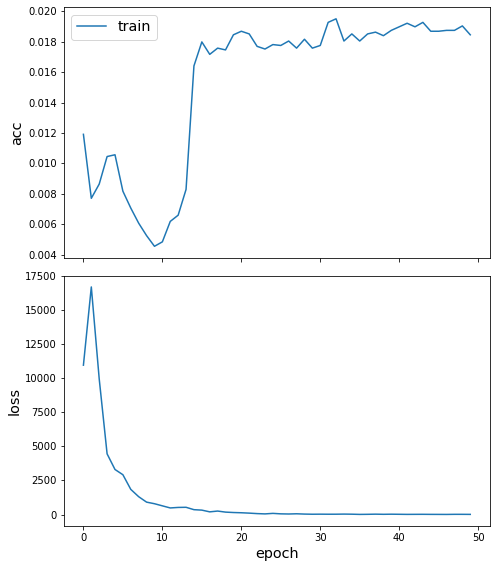

In [42]:
sg.utils.plot_history(history)

In [29]:
test_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 7s 7s/step - loss: 0.0059 - acc: 0.0194

Test Set Metrics:
	loss: 0.0059
	acc: 0.0194


## prediction for genes of controls (GCN)

In [31]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions[0], index =controlsDK.index,columns =controlsDK.columns)

In [32]:
genesEmbeddings

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                              0.004692                     -0.019996   
2                              0.004692                     -0.019996   
9                              0.004692                     -0.019996   
10                             0.004692                     -0.019996   
12                             0.004692                     -0.019996   
...                                 ...                           ...   
100302401                      0.003171                     -0.022571   
100302640                      0.004692                     -0.019996   
100302692                      0.004692                     -0.019996   
100302736                      0.004692                     -0.019996   
100303728                      0.004692                     -0.019996   

           TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                              0.036509                      0.038886   
2                              0.036509                      0.038886   
9                              0.036509                      0.038886   
10                             0.036509                      0.038886   
12                             0.036509                      0.038886   
...                                 ...                           ...   
100302401                      0.039229                      0.039760   
100302640                      0.036509                      0.038886   
100302692                      0.036509                      0.038886   
100302736                      0.036509                      0.038886   
100303728                      0.036509                      0.038886   

           TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                             -0.058539                      0.034009   
2                             -0.058539                      0.034009   
9                             -0.058539                      0.034009   
10                            -0.058539                      0.034009   
12                            -0.058539                      0.034009   
...                                 ...                           ...   
100302401                     -0.058792                      0.035916   
100302640                     -0.058539                      0.034009   
100302692                     -0.058539                      0.034009   
100302736                     -0.058539                      0.034009   
100303728                     -0.058539                      0.034009   

           TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                             -0.013628                      0.087353   
2                             -0.013628                      0.087353   
9                             -0.013628                      0.087353   
10                            -0.013628                      0.087353   
12                            -0.013628                      0.087353   
...                                 ...                           ...   
100302401                     -0.014336                      0.084949   
100302640                     -0.013628                      0.087353   
100302692                     -0.013628                      0.087353   
100302736                     -0.013628                      0.087353   
100303728                     -0.013628                      0.087353   

           TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                             -0.047503                     -0.000832  ...   
2                             -0.047503                     -0.000832  ...   
9                             -0.047503                     -0.000832  ...   
10                            -0.047503                     -0.000832  ...   
12                            -0.047503                     -0.000832  ...   
...                                

<AxesSubplot:>

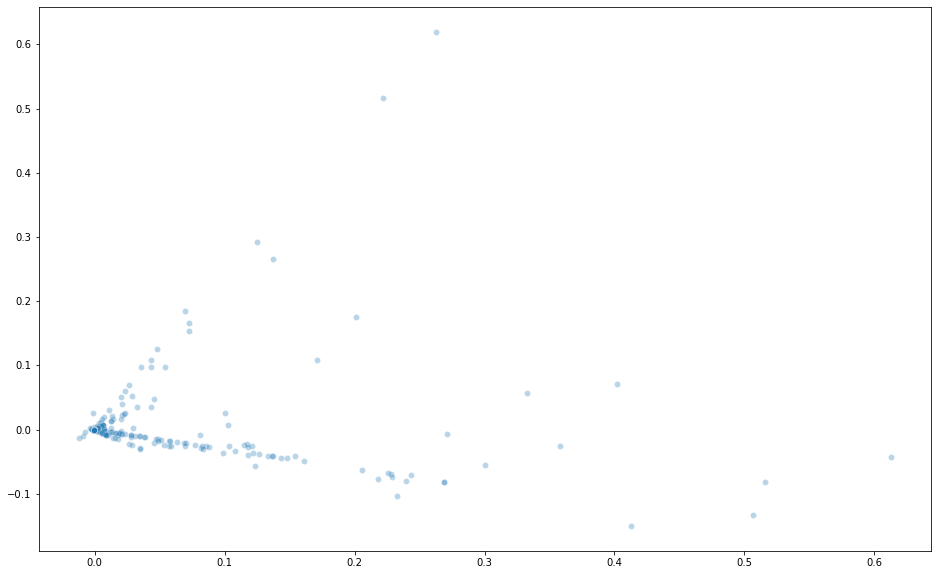

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

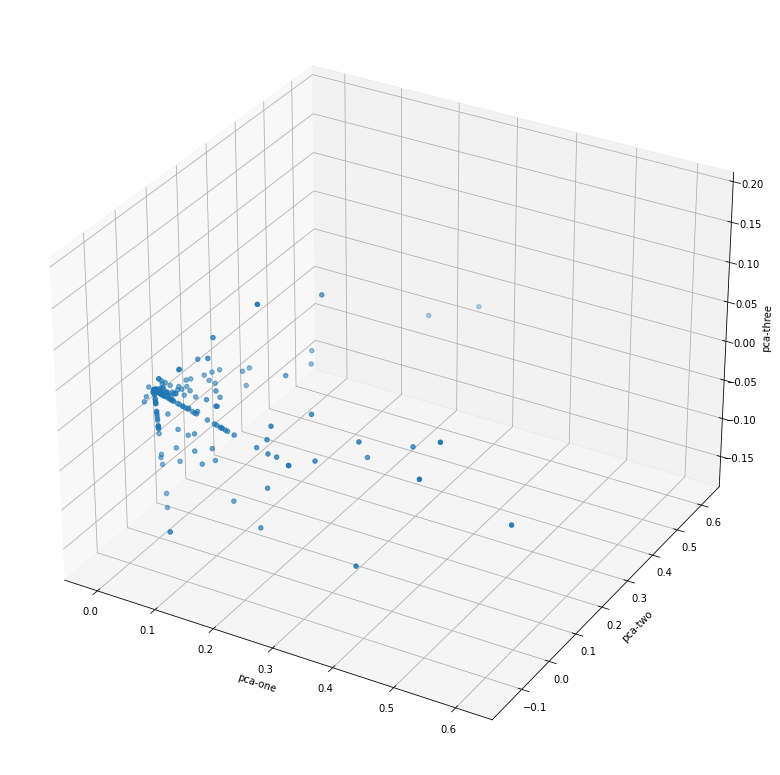

In [34]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE (controls)

10 nodes in the first layer(5 in and 5 out) and 4 nodes in the second layer

In [30]:
batch_size = controlsDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_size

17129

In [31]:
generator = DirectedGraphSAGENodeGenerator(directedGraph, batch_size, in_samples, out_samples)

In [32]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGen = generator.flow(controlsDK.index, controlsDK)

graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=controlsDK.shape[1], activation="softmax")(x_out)

In [33]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 113)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5, 113)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10, 113)]    0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10, 113)]    0           []                               
                                                                                              

In [34]:
checkpointPath = "model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)


model.load_weights(checkpointPath)

In [32]:
history = model.fit(
    trainGen, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_size,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 27s - loss: 0.1331 - acc: 0.0074 - 27s/epoch - 27s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.1119 - acc: 0.0076 - 24s/epoch - 24s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.1012 - acc: 0.0061 - 25s/epoch - 25s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0809 - acc: 0.0056 - 25s/epoch - 25s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0713 - acc: 0.0051 - 25s/epoch - 25s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 25s - loss: 0.0679 - acc: 0.0051 - 25s/epoch - 25s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.0759 - acc: 0.0058 - 24s/ep

In [33]:
model.save_weights(checkpointPath.format(epoch=0))

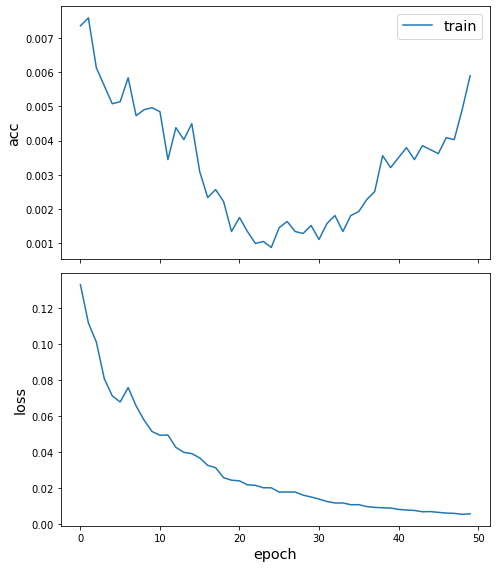

In [34]:
sg.utils.plot_history(history)

## prediction for genes of controls (GRAPHSAGE)

In [35]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions, index =controlsDK.index,columns =controlsDK.columns)

In [36]:
genesEmbeddings

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                              0.008809                      0.008103   
2                              0.008774                      0.008106   
9                              0.008810                      0.008104   
10                             0.008815                      0.008285   
12                             0.008810                      0.008104   
...                                 ...                           ...   
100302401                      0.008622                      0.008470   
100302640                      0.008771                      0.008361   
100302692                      0.008809                      0.008103   
100302736                      0.008832                      0.008110   
100303728                      0.008805                      0.008095   

           TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                              0.009435                      0.007700   
2                              0.009473                      0.007619   
9                              0.009436                      0.007702   
10                             0.009376                      0.007529   
12                             0.009436                      0.007702   
...                                 ...                           ...   
100302401                      0.009315                      0.007489   
100302640                      0.009399                      0.007837   
100302692                      0.009435                      0.007700   
100302736                      0.009447                      0.007725   
100303728                      0.009425                      0.007690   

           TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                              0.009389                      0.010149   
2                              0.009658                      0.010400   
9                              0.009390                      0.010150   
10                             0.009407                      0.010066   
12                             0.009390                      0.010150   
...                                 ...                           ...   
100302401                      0.009212                      0.009768   
100302640                      0.009565                      0.010143   
100302692                      0.009389                      0.010149   
100302736                      0.009364                      0.010141   
100303728                      0.009376                      0.010136   

           TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                              0.009932                      0.008103   
2                              0.009956                      0.008396   
9                              0.009931                      0.008101   
10                             0.009792                      0.008158   
12                             0.009931                      0.008101   
...                                 ...                           ...   
100302401                      0.009880                      0.007959   
100302640                      0.009739                      0.008029   
100302692                      0.009932                      0.008103   
100302736                      0.009893                      0.008053   
100303728                      0.009932                      0.008111   

           TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                              0.008418                      0.009885  ...   
2                              0.008694                      0.010055  ...   
9                              0.008417                      0.009884  ...   
10                             0.008143                      0.009766  ...   
12                             0.008417                      0.009884  ...   
...                                

Column names are only **indicative**, they are not the patients since these features are the embeddings.

<AxesSubplot:>

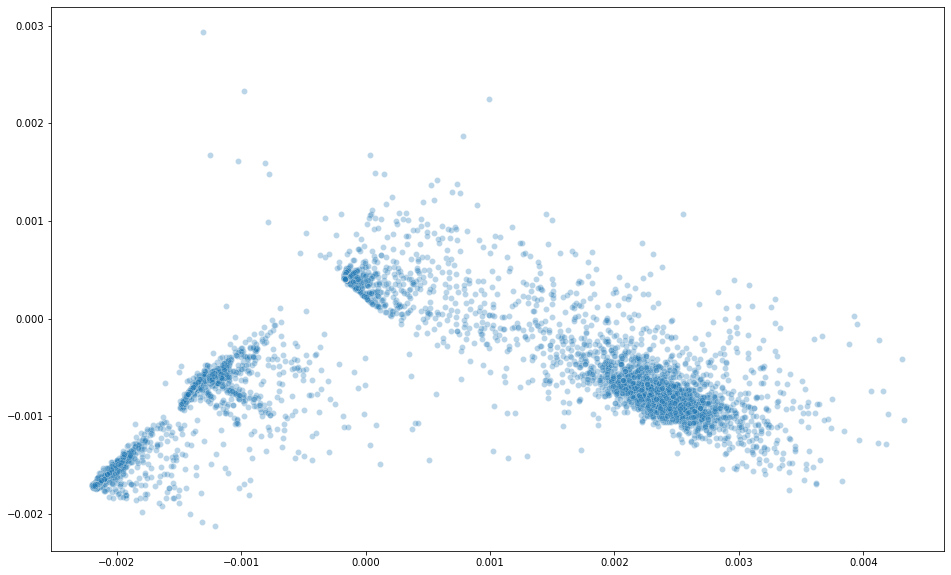

In [37]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

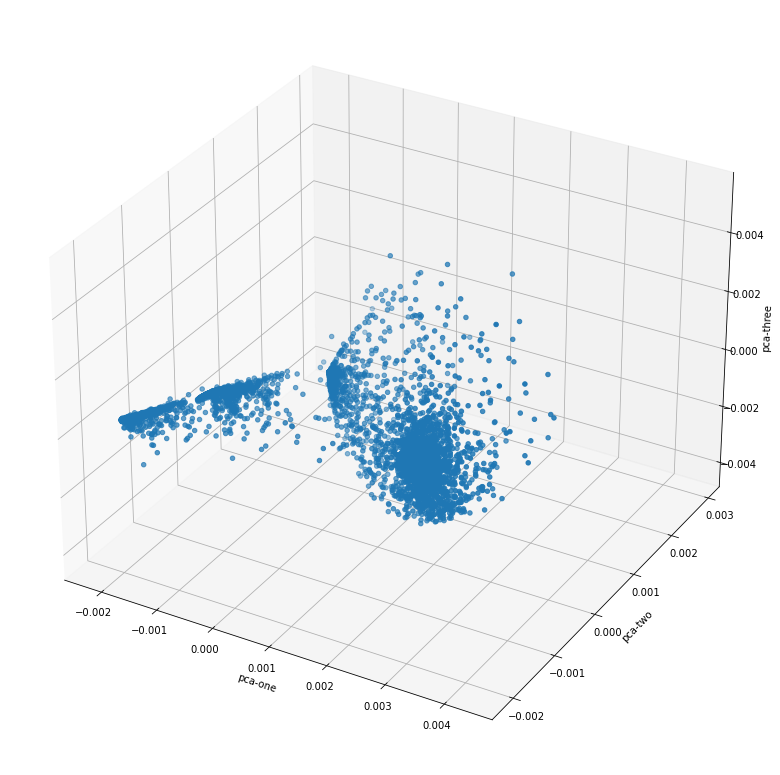

In [38]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Genes embeddings for Tumors

### preliminary steps

In [39]:
indexOfGenesTumor = dict()

for i in range(0,len(tumorDKfull.index)):
    indexOfGenesTumor[tumorDKfull.index[i]] = i

tensorEdgesTumor = tf.constant(geneEdgesTumor,tf.int32)
tensorEdgesTestTumor = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenesTumor[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdgesTumor)  # take only edges with no weight

**using the full dataset for the constant vector used in the loss function for both the reduced dataset(with less columns) and the full dataset since the final product is the same**

In [40]:
tfTumor = tf.constant(tumorDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)
maxDegreeTumor = 0

for gene in list(tumorDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegreeTumor):
        maxDegreeTumor = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantListTumor,constantTensorTumor = precomputeCostantsTensor(tensorEdgesTumor,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegreeTumor)
constantTensorTumor

<tf.Tensor: shape=(17264,), dtype=float32, numpy=
array([4.4326767e-05, 1.4577259e-05, 1.4577259e-05, ..., 1.4577259e-05,
       1.4577259e-05, 1.4577259e-05], dtype=float32)>

### true embeddings for all patients tumor

In [35]:
graphTumorWithFeatures = sg.StellarGraph(tumorDKfull ,geneEdgesTumor )
print(graphTumorWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 1082
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [36]:
generatorTumor = FullBatchNodeGenerator(graphTumorWithFeatures, method="gcn")
trainGenTumor = generatorTumor.flow(tumorDKfull.index,tumorDKfull)
gcnTumor = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generatorTumor, dropout=0.5
)

Using GCN (local pooling) filters...


In [37]:
x_inpTumor, x_outTumor = gcnTumor.in_out_tensors()
predictionsTumorFull = layers.Dense(tumorDKfull.shape[1], kernel_initializer='normal')(x_outTumor)

In [41]:
modelTumor = Model(inputs=x_inpTumor , outputs=predictionsTumorFull)

modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    metrics=["acc"])

In [42]:
modelTumor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 19727, 1082)]   0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 19727, 1082)     0           ['input_5[0][0]']                
                                                                                            

In [43]:
checkpointPathTumor = "model_checkpoints/adamGenesTumor.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callbackTumor = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)

modelTumor.load_weights(checkpointPathTumor)

In [103]:
historyTumor = modelTumor.fit(
    trainGenTumor,
    epochs=10,
    #validation_data=val_gen,
    batch_size=tumorDKfull.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callbackTumor]
)

Epoch 1/10

Epoch 1: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 48.7121 - acc: 3.0415e-04 - 113s/epoch - 113s/step
Epoch 2/10

Epoch 2: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 16.3105 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 3/10

Epoch 3: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 112s - loss: 18.2850 - acc: 1.0138e-04 - 112s/epoch - 112s/step
Epoch 4/10

Epoch 4: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 17.8057 - acc: 2.5346e-04 - 113s/epoch - 113s/step
Epoch 5/10

Epoch 5: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 25.7509 - acc: 2.0277e-04 - 113s/epoch - 113s/step
Epoch 6/10

Epoch 6: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 22.5953 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 7/10

Epoch 7: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 23.7553 - acc: 2.5346e-04 - 113s/epo

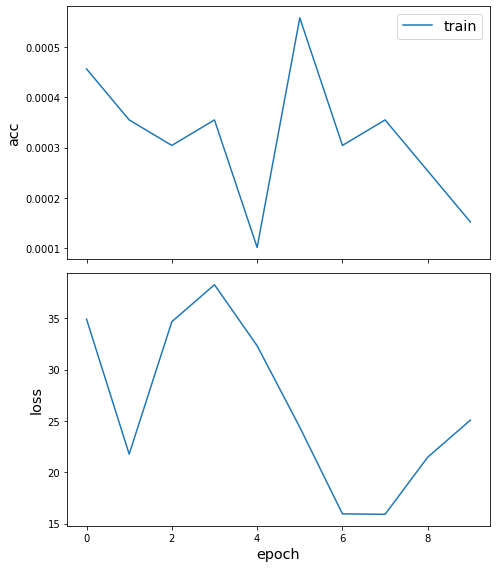

In [126]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))
sg.utils.plot_history(historyTumor)

## prediction for genes of tumors (GCN)

In [45]:
all_mapper = generatorTumor.flow(tumorDKfull.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions[0], index =tumorDKfull.index,columns =tumorDKfull.columns)

In [46]:
genesEmbeddingsTumor

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2             0.077756         0.024824        -0.013002        -0.034736   
3             0.077756         0.024824        -0.013002        -0.034736   
7             0.077756         0.024824        -0.013002        -0.034736   
8             0.077756         0.024824        -0.013002        -0.034736   
10            0.077756         0.024824        -0.013002        -0.034736   
...                ...              ...              ...              ...   
20526         0.077756         0.024824        -0.013002        -0.034736   
20527         0.077756         0.024824        -0.013002        -0.034736   
20528         0.077756         0.024824        -0.013002        -0.034736   
20529         0.077756         0.024824        -0.013002        -0.034736   
20530         0.077756         0.024824        -0.013002        -0.034736   

       TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2             0.055104         0.037664         0.052124          0.02696   
3             0.055104         0.037664         0.052124          0.02696   
7             0.055104         0.037664         0.052124          0.02696   
8             0.055104         0.037664         0.052124          0.02696   
10            0.055104         0.037664         0.052124          0.02696   
...                ...              ...              ...              ...   
20526         0.055104         0.037664         0.052124          0.02696   
20527         0.055104         0.037664         0.052124          0.02696   
20528         0.055104         0.037664         0.052124          0.02696   
20529         0.055104         0.037664         0.052124          0.02696   
20530         0.055104         0.037664         0.052124          0.02696   

       TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-UL-AAZ6-01  \
2             0.012788        -0.045989  ...         0.025012   
3             0.012788        -0.045989  ...         0.025012   
7             0.012788        -0.045989  ...         0.025012   
8             0.012788        -0.045989  ...         0.025012   
10            0.012788        -0.045989  ...         0.025012   
...                ...              ...  ...              ...   
20526         0.012788        -0.045989  ...         0.025012   
20527         0.012788        -0.045989  ...         0.025012   
20528         0.012788        -0.045989  ...         0.025012   
20529         0.012788        -0.045989  ...         0.025012   
20530         0.012788        -0.045989  ...         0.025012   

       TCGA-UU-A93S-01  TCGA-V7-A7HQ-01  TCGA-W8-A86G-01  TCGA-WT-AB41-01  \
2             0.034019         0.027135         0.013607        -0.033031   
3             0.034019         0.027135         0.013607        -0.033031   
7             0.034019         0.027135         0.013607        -0.033031   
8             0.034019         0.027135         0.013607        -0.033031   
10            0.034019         0.027135         0.013607        -0.033031   
...                ...              ...              ...              ...   
20526         0.034019         0.027135         0.013607        -0.033031   
20527         0.034019         0.027135         0.013607        -0.033031   
20528         0.034019         0.027135         0.013607        -0.033031   
20529         0.034019         0.027135         0.013607        -0.033031   
20530         0.034019         0.027135         0.013607        -0.033031   

       TCGA-WT-AB44-01  TCGA-XX-A899-01  TCGA-XX-A89A-01  TCGA-Z7-A8R5-01  \
2            -0.013939        -0.051558        -0.083843        -0.013089   
3            -0.013939        -0.051558        -0.083843        -0.013089   
7            -0.013939        -0.051558        -0.083843        -0.013089   
8            -0.013939        -0.051558        -0.083843        -0.013089   
10           -0.013939        -0.051558        -0.083843        -0

<AxesSubplot:>

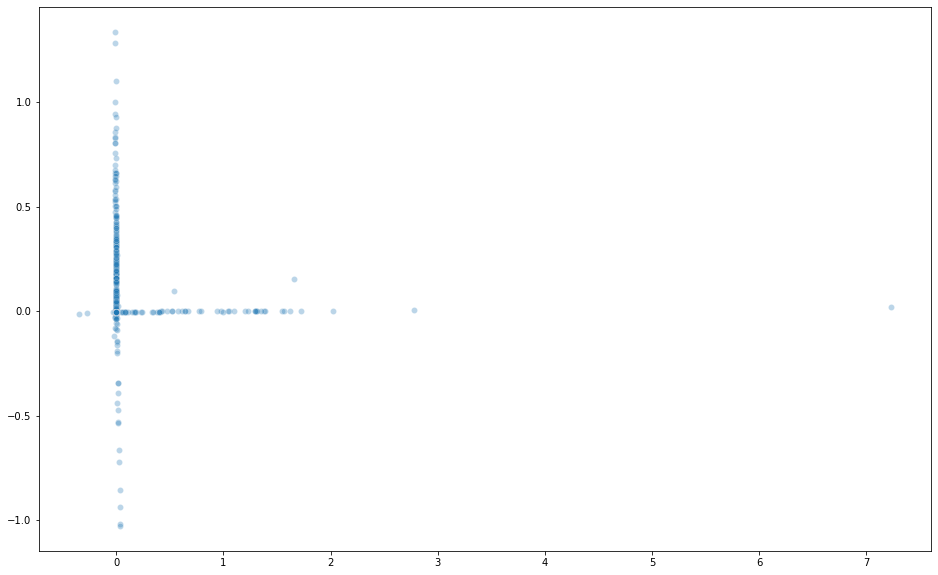

In [48]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

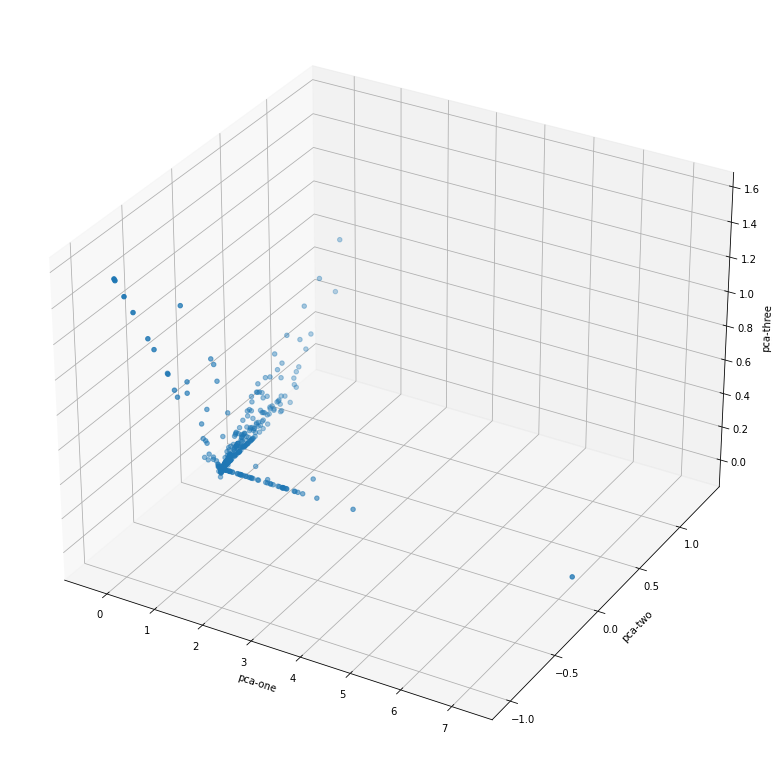

In [49]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors

In [41]:
directedGraphTumor = sg.StellarDiGraph(tumorDK ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 390
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [42]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [43]:
generatorTumor = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [44]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumor = generatorTumor.flow(tumorDK.index, tumorDK)

graphsage_modelTumor = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumor, bias=False, dropout=0.5,
)

x_inpTumor, x_outTumor = graphsage_modelTumor.in_out_tensors()
predictionTumor = layers.Dense(units=tumorDK.shape[1], activation="softmax")(x_outTumor)


In [45]:
modelTumor = Model(inputs=x_inpTumor, outputs=predictionTumor)
modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumor.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 390)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 390)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                            

In [46]:
checkpointPathTumor = "model_checkpoints/GRAPHSAGEtumorGenes.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumor.load_weights(checkpointPathTumor)

In [47]:
history = modelTumor.fit(
    trainGenTumor, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 29s - loss: 0.0092 - acc: 0.0025 - 29s/epoch - 29s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 26s - loss: 0.0087 - acc: 0.0026 - 26s/epoch - 26s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0075 - acc: 0.0028 - 28s/epoch - 28s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 27s - loss: 0.0065 - acc: 0.0019 - 27s/epoch - 27s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0057 - acc: 0.0022 - 28s/epoch - 28s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0052 - acc: 0.0026 - 28s/epoch - 28s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 0.0046 - acc: 0.0019 - 28s/epoch - 28s/step
Epoch 

In [48]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))

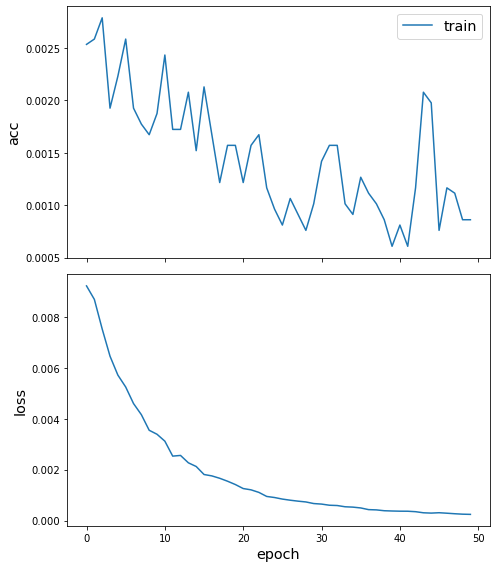

In [49]:
sg.utils.plot_history(history)

## prediction for genes of tumors

In [50]:
all_mapper = generatorTumor.flow(tumorDK.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions, index =tumorDK.index,columns =tumorDK.columns)

In [51]:
genesEmbeddingsTumor

TCGA-A2-A1FX  TCGA-D8-A1XB  TCGA-BH-A0E1  TCGA-AQ-A04J  TCGA-BH-A0E9  \
2          0.002660      0.002772      0.002760      0.002250      0.002473   
3          0.002651      0.002782      0.002746      0.002272      0.002439   
7          0.002666      0.002773      0.002760      0.002254      0.002480   
8          0.002668      0.002772      0.002759      0.002255      0.002481   
10         0.002666      0.002771      0.002758      0.002255      0.002483   
...             ...           ...           ...           ...           ...   
20526      0.002648      0.002774      0.002758      0.002257      0.002473   
20527      0.002667      0.002772      0.002760      0.002255      0.002481   
20528      0.002671      0.002773      0.002760      0.002255      0.002481   
20529      0.002667      0.002772      0.002759      0.002255      0.002481   
20530      0.002666      0.002776      0.002764      0.002252      0.002481   

       TCGA-C8-A133  TCGA-B6-A0IG  TCGA-LL-A8F5  TCGA-E2-A14Q  TCGA-AR-A2LQ  \
2          0.002536      0.002290      0.002261      0.002823      0.002485   
3          0.002522      0.002335      0.002236      0.002835      0.002458   
7          0.002532      0.002281      0.002258      0.002824      0.002481   
8          0.002531      0.002281      0.002259      0.002824      0.002481   
10         0.002534      0.002278      0.002254      0.002828      0.002481   
...             ...           ...           ...           ...           ...   
20526      0.002542      0.002278      0.002237      0.002836      0.002476   
20527      0.002531      0.002281      0.002258      0.002824      0.002480   
20528      0.002529      0.002282      0.002262      0.002824      0.002480   
20529      0.002531      0.002282      0.002258      0.002825      0.002480   
20530      0.002533      0.002279      0.002261      0.002824      0.002478   

       ...  TCGA-A2-A0YI  TCGA-A2-A4S1  TCGA-A8-A07B  TCGA-AC-A5XS  \
2      ...      0.002392      0.002789      0.002362      0.002719   
3      ...      0.002405      0.002802      0.002377      0.002721   
7      ...      0.002391      0.002788      0.002351      0.002711   
8      ...      0.002392      0.002790      0.002350      0.002713   
10     ...      0.002396      0.002788      0.002350      0.002712   
...    ...           ...           ...           ...           ...   
20526  ...      0.002392      0.002781      0.002357      0.002709   
20527  ...      0.002392      0.002790      0.002352      0.002712   
20528  ...      0.002392      0.002792      0.002348      0.002715   
20529  ...      0.002393      0.002789      0.002351      0.002712   
20530  ...      0.002389      0.002791      0.002353      0.002712   

       TCGA-GM-A5PV  TCGA-A1-A0SI  TCGA-AC-A2BK  TCGA-OL-A5DA  TCGA-AR-A254  \
2          0.002388      0.002747      0.002722      0.002255      0.002526   
3          0.002401      0.002768      0.002696      0.002200      0.002557   
7          0.002382      0.002746      0.002732      0.002250      0.002523   
8          0.002382      0.002747      0.002732      0.002251      0.002523   
10         0.002386      0.002750      0.002730      0.002250      0.002519   
...             ...           ...           ...           ...           ...   
20526      0.002397      0.002758      0.002729      0.002234      0.002521   
20527      0.002382      0.002746      0.002732      0.002251      0.002523   
20528      0.002381      0.002747      0.002731      0.002251      0.002526   
20529      0.002383      0.002747      0.002731      0.002250      0.002523   
20530      0.002384      0.002743      0.002733      0.002252      0.002526   

       TCGA-B6-A0I9  
2          0.002586  
3          0.002618  
7          0.002584  
8          0.002586  
10         0.002587  
...             ...  
20526      0.002589  
20527      0.002586  
20528      0.002587  
20529      0.002586  
20530      0.002584  

[19727 rows x 390 columns]

As already said, column names are only **indicative**, they are not the patients since these features are the embeddings.

### visualizzazione dati di espressione

<AxesSubplot:>

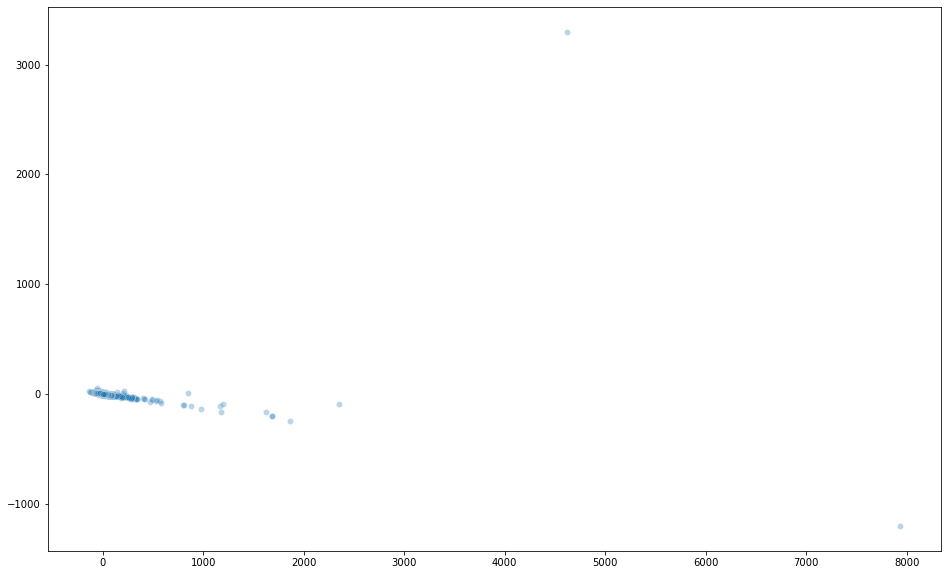

In [52]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tumorDK)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

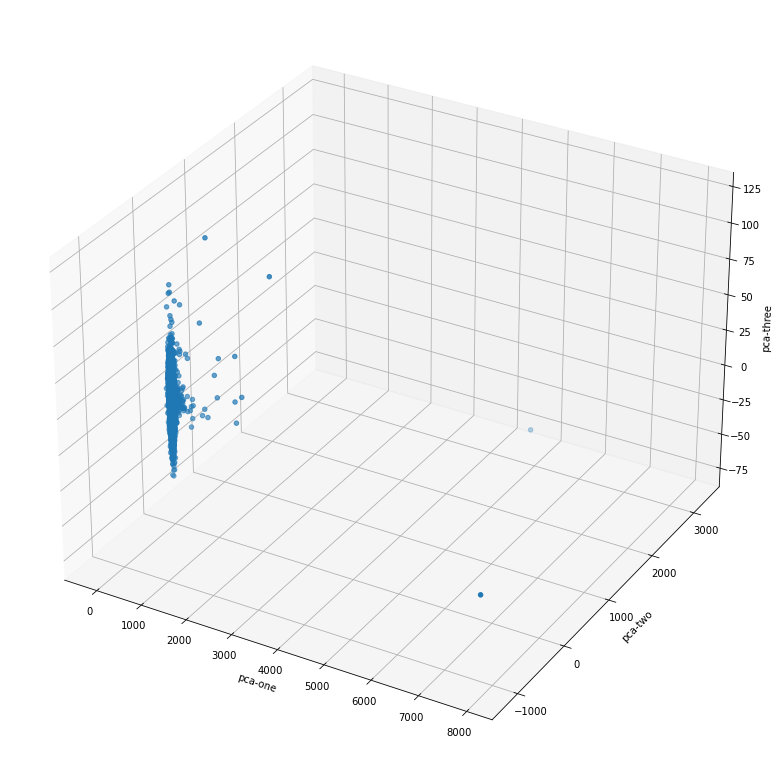

In [74]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### visualizzazione embeddings

<AxesSubplot:>

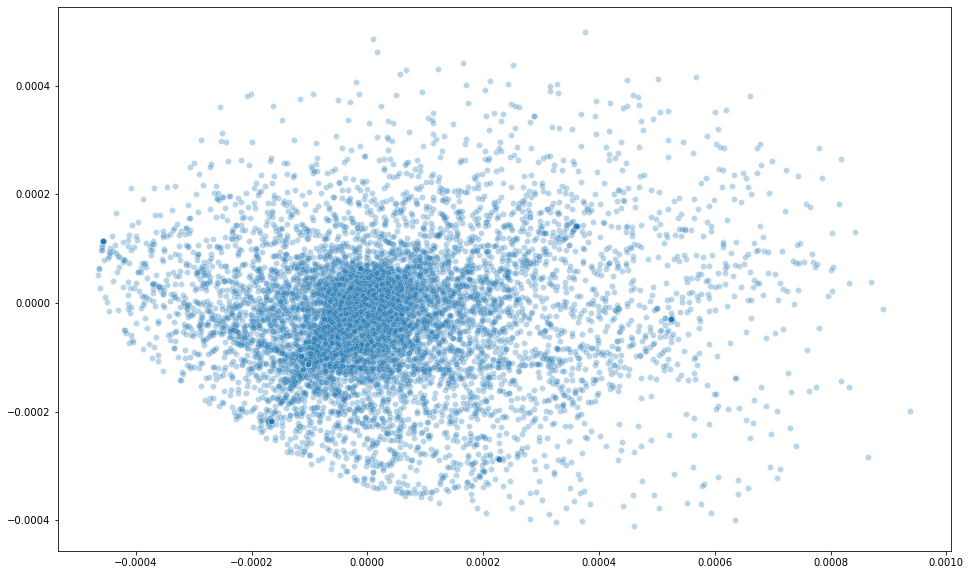

In [53]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

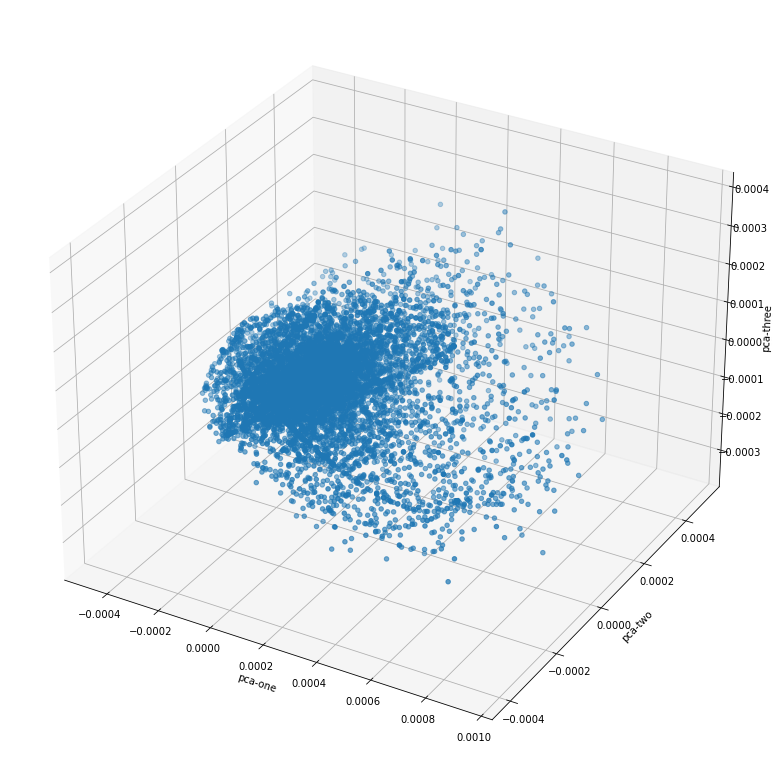

In [54]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors(same number of features as controls)

In [55]:
#tumorDKfinal = tumorDKfull.sample(n=controlsDK.shape[1], axis='columns', random_state=2)
tumorDKfinal = tumorDKfull.iloc[: , :controlsDK.shape[1]]
directedGraphTumorfinal = sg.StellarDiGraph(tumorDKfinal ,geneEdgesTumor)
print(directedGraphTumorfinal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [56]:
batch_sizeTumor = int(tumorDKfinal.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [57]:
generatorTumorfinal = DirectedGraphSAGENodeGenerator(directedGraphTumorfinal, batch_sizeTumor, in_samples, out_samples)

In [58]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorfinal.flow(tumorDKfinal.index, tumorDKfinal)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorfinal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=tumorDKfinal.shape[1], activation="softmax")(x_outTumorfinal)


In [59]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [42]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [119]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9562 - acc: 0.0068 - 15s/epoch - 15s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9475 - acc: 0.0050 - 15s/epoch - 15s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.7388 - acc: 0.0034 - 15s/epoch - 15s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.7063 - acc: 0.0034 - 16s/epoch - 16s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.5977 - acc: 0.0033 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.5195 - acc: 0.0032 - 15s/epoch - 15s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patie

In [120]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

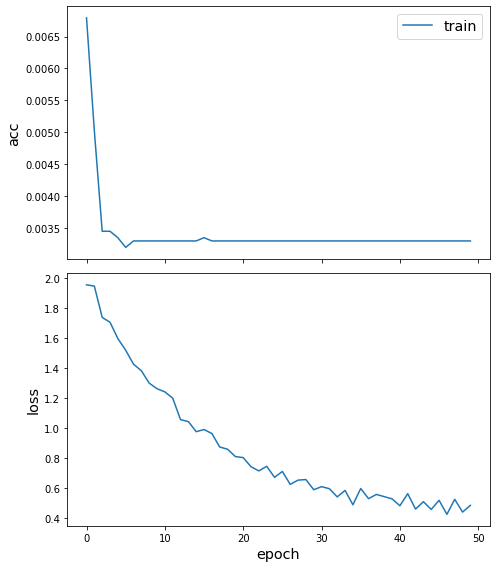

In [121]:
sg.utils.plot_history(history)

### generazione embedding per tumor con lo stesso numero di feature di control

In [43]:
all_mapper = generatorTumorfinal.flow(tumorDKfinal.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorfinal = pd.DataFrame(all_predictions, index =tumorDKfinal.index,columns =tumorDKfinal.columns)

In [44]:
genesEmbeddingsTumorfinal

TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  TCGA-3C-AALK-01  \
2             0.006832         0.006949         0.007543         0.006660   
3             0.006834         0.006957         0.007542         0.006666   
7             0.006835         0.006959         0.007541         0.006660   
8             0.006834         0.006959         0.007540         0.006660   
10            0.006835         0.006960         0.007540         0.006660   
...                ...              ...              ...              ...   
20526         0.006831         0.006956         0.007538         0.006660   
20527         0.006834         0.006959         0.007540         0.006660   
20528         0.006834         0.006960         0.007540         0.006660   
20529         0.006834         0.006959         0.007540         0.006660   
20530         0.006834         0.006959         0.007540         0.006660   

       TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  TCGA-5T-A9QA-01  TCGA-A1-A0SB-01  \
2             0.009087         0.010477         0.010361         0.007585   
3             0.009085         0.010482         0.010368         0.007603   
7             0.009084         0.010472         0.010371         0.007585   
8             0.009085         0.010472         0.010372         0.007585   
10            0.009086         0.010473         0.010371         0.007587   
...                ...              ...              ...              ...   
20526         0.009084         0.010479         0.010368         0.007591   
20527         0.009085         0.010472         0.010371         0.007584   
20528         0.009086         0.010473         0.010371         0.007587   
20529         0.009085         0.010472         0.010372         0.007585   
20530         0.009084         0.010472         0.010372         0.007584   

       TCGA-A1-A0SD-01  TCGA-A1-A0SE-01  ...  TCGA-A2-A25F-01  \
2             0.006659         0.008082  ...         0.009688   
3             0.006662         0.008072  ...         0.009688   
7             0.006656         0.008076  ...         0.009693   
8             0.006655         0.008076  ...         0.009693   
10            0.006656         0.008075  ...         0.009692   
...                ...              ...  ...              ...   
20526         0.006658         0.008081  ...         0.009694   
20527         0.006655         0.008076  ...         0.009693   
20528         0.006656         0.008076  ...         0.009693   
20529         0.006655         0.008076  ...         0.009693   
20530         0.006655         0.008076  ...         0.009693   

       TCGA-A2-A3KC-01  TCGA-A2-A3KD-01  TCGA-A2-A3XS-01  TCGA-A2-A3XT-01  \
2             0.009826         0.007555         0.009018         0.010200   
3             0.009829         0.007539         0.009023         0.010202   
7             0.009835         0.007543         0.009019         0.010198   
8             0.009836         0.007543         0.009019         0.010199   
10            0.009835         0.007543         0.009020         0.010199   
...                ...              ...              ...              ...   
20526         0.009831         0.007548         0.009020         0.010200   
20527         0.009836         0.007544         0.009019         0.010198   
20528         0.009836         0.007543         0.009020         0.010199   
20529         0.009836         0.007544         0.009019         0.010198   
20530         0.009835         0.007544         0.009019         0.010198   

       TCGA-A2-A3XU-01  TCGA-A2-A3XV-01  TCGA-A2-A3XW-01  TCGA-A2-A3XX-01  \
2             0.009970         0.010301         0.010654         0.006951   
3             0.009974         0.010303         0.010653         0.006961   
7             0.009966         0.010302         0.010657         0.006955   
8             0.009966         0.010302         0.010657         0.006955   
10            0.009967         0.010302         0.010656         0

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

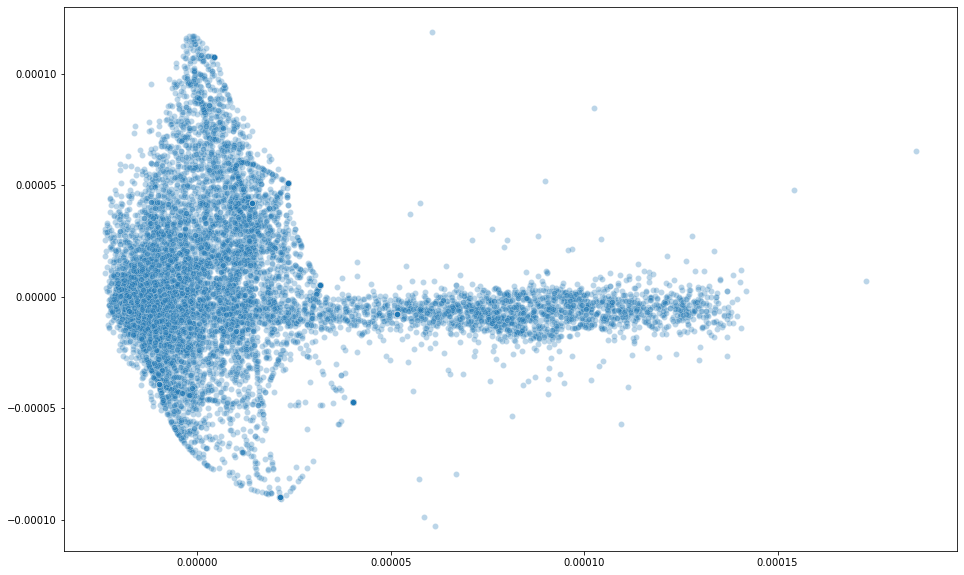

In [45]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorfinal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

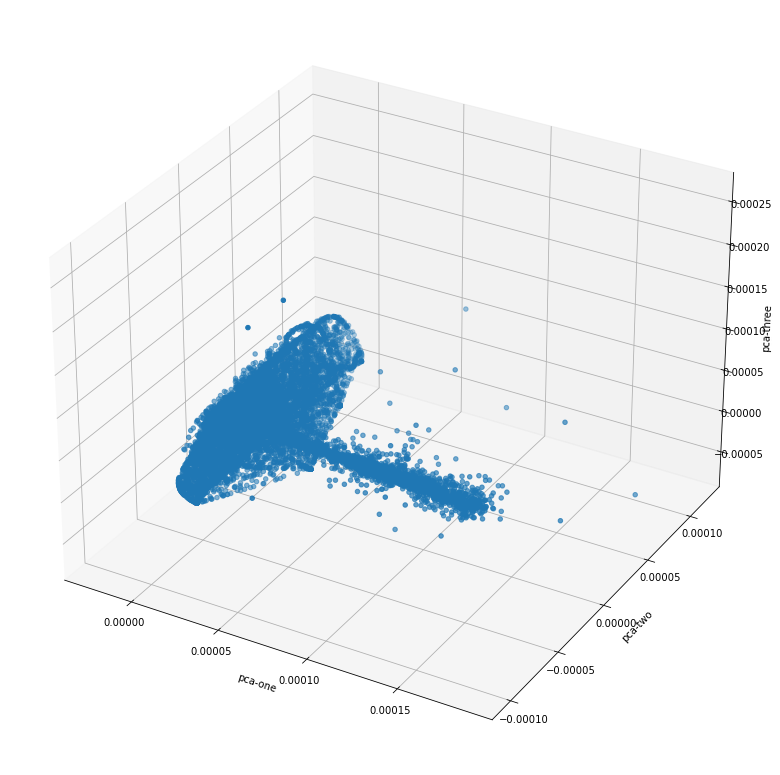

In [46]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Embeddings Graphsage for **Basal** tumors

In [129]:
directedGraphTumorBasal = sg.StellarDiGraph(basalExprMatrix ,geneEdgesTumor)
print(directedGraphTumorBasal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 171
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [130]:
batch_sizeTumor = int(tumorDKfinal.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [131]:
generatorTumorBasal = DirectedGraphSAGENodeGenerator(directedGraphTumorBasal, batch_sizeTumor, in_samples, out_samples)

In [136]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorBasal.flow(tumorDKfinal.index, tumorDKfinal)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorBasal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=basalExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [137]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                            

In [138]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [139]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 74s - loss: 49.2269 - acc: 0.0068 - 74s/epoch - 74s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 74s - loss: 44.9268 - acc: 0.0066 - 74s/epoch - 74s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 80s - loss: 40.5904 - acc: 0.0073 - 80s/epoch - 80s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 37.1797 - acc: 0.0067 - 83s/epoch - 83s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 33.6647 - acc: 0.0056 - 83s/epoch - 83s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 83s - loss: 30.4873 - acc: 0.0065 - 83s/epoch - 83s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal.ckpt
1/1 - 84s - loss: 27.2234 -

In [140]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

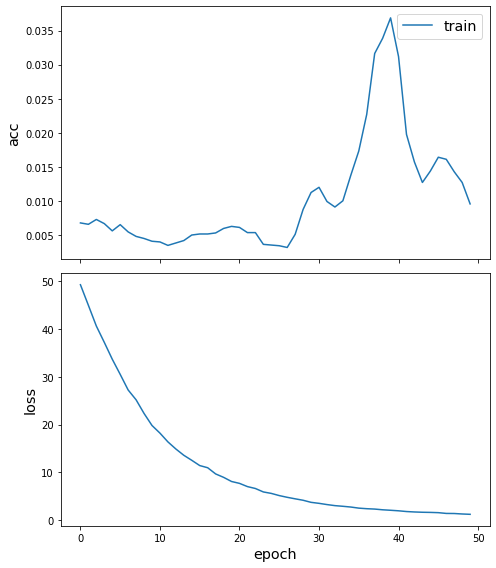

In [141]:
sg.utils.plot_history(history)

### generazione embedding per tumor Basal

In [143]:
all_mapper = generatorTumorBasal.flow(basalExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorBasal = pd.DataFrame(all_predictions, index =basalExprMatrix.index,columns =basalExprMatrix.columns)

In [145]:
genesEmbeddingsTumorBasal

TCGA-A1-A0SK  TCGA-A1-A0SO  TCGA-A1-A0SP  TCGA-A2-A04P  TCGA-A2-A04Q  \
2          0.005929      0.005155      0.005078      0.006355      0.006508   
3          0.005907      0.005103      0.005061      0.006328      0.006505   
7          0.005903      0.005144      0.005078      0.006355      0.006518   
8          0.005904      0.005143      0.005076      0.006352      0.006520   
10         0.005902      0.005143      0.005083      0.006358      0.006518   
...             ...           ...           ...           ...           ...   
20526      0.005872      0.005147      0.005073      0.006342      0.006521   
20527      0.005905      0.005144      0.005076      0.006352      0.006519   
20528      0.005916      0.005137      0.005091      0.006346      0.006511   
20529      0.005904      0.005145      0.005078      0.006355      0.006518   
20530      0.005901      0.005143      0.005077      0.006356      0.006518   

       TCGA-A2-A04T  TCGA-A2-A04U  TCGA-A2-A0CM  TCGA-A2-A0D0  TCGA-A2-A0D2  \
2          0.004770      0.006097      0.005970      0.006383      0.004995   
3          0.004734      0.006104      0.005979      0.006378      0.004989   
7          0.004769      0.006107      0.005986      0.006363      0.005007   
8          0.004770      0.006106      0.005984      0.006364      0.005005   
10         0.004754      0.006106      0.005971      0.006370      0.005002   
...             ...           ...           ...           ...           ...   
20526      0.004738      0.006109      0.005996      0.006382      0.005013   
20527      0.004771      0.006105      0.005986      0.006363      0.005005   
20528      0.004766      0.006095      0.005968      0.006368      0.005000   
20529      0.004769      0.006106      0.005986      0.006362      0.005007   
20530      0.004765      0.006107      0.005985      0.006363      0.005006   

       ...  TCGA-OL-A5D7  TCGA-OL-A5RW  TCGA-OL-A5S0  TCGA-OL-A66I  \
2      ...      0.005625      0.005052      0.006508      0.004907   
3      ...      0.005651      0.005080      0.006515      0.004874   
7      ...      0.005628      0.005066      0.006496      0.004886   
8      ...      0.005626      0.005068      0.006496      0.004886   
10     ...      0.005633      0.005061      0.006486      0.004896   
...    ...           ...           ...           ...           ...   
20526  ...      0.005611      0.005051      0.006503      0.004879   
20527  ...      0.005626      0.005068      0.006497      0.004886   
20528  ...      0.005617      0.005058      0.006514      0.004876   
20529  ...      0.005629      0.005066      0.006496      0.004886   
20530  ...      0.005631      0.005066      0.006495      0.004886   

       TCGA-OL-A6VO  TCGA-PL-A8LV  TCGA-PL-A8LZ  TCGA-S3-AA0Z  TCGA-S3-AA10  \
2          0.006336      0.006102      0.004765      0.006508      0.005240   
3          0.006354      0.006123      0.004782      0.006513      0.005232   
7          0.006322      0.006109      0.004776      0.006508      0.005241   
8          0.006319      0.006108      0.004777      0.006508      0.005240   
10         0.006300      0.006073      0.004801      0.006510      0.005239   
...             ...           ...           ...           ...           ...   
20526      0.006349      0.006121      0.004796      0.006523      0.005213   
20527      0.006320      0.006110      0.004773      0.006508      0.005242   
20528      0.006310      0.006100      0.004783      0.006501      0.005249   
20529      0.006321      0.006109      0.004776      0.006508      0.005241   
20530      0.006323      0.006108      0.004780      0.006508      0.005238   

       TCGA-S3-AA15  
2          0.006065  
3          0.006100  
7          0.006091  
8          0.006088  
10         0.006069  
...             ...  
20526      0.006105  
20527      0.006088  
20528      0.006091  
20529      0.006091  
20530      0.006094  

[19727 rows x 171 columns]

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

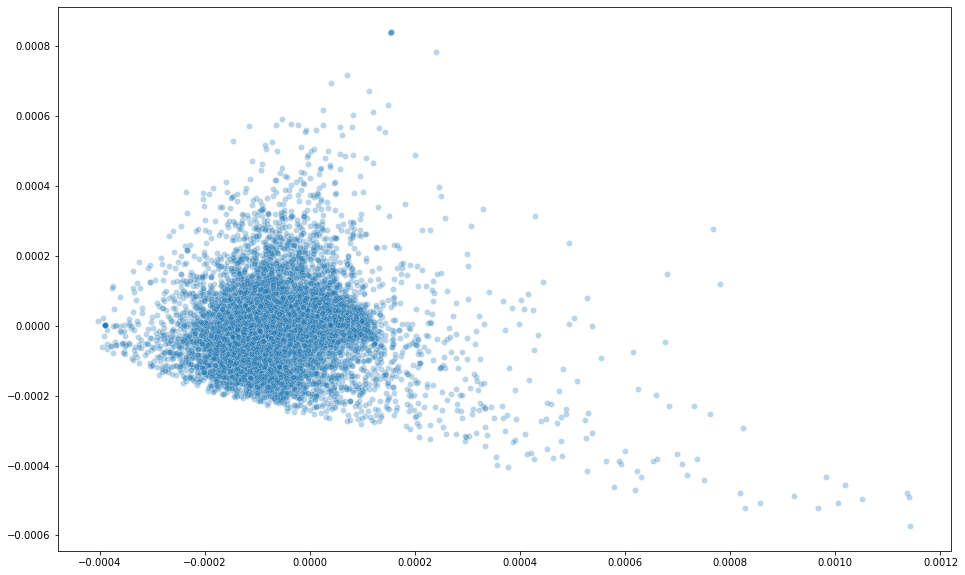

In [146]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorBasal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

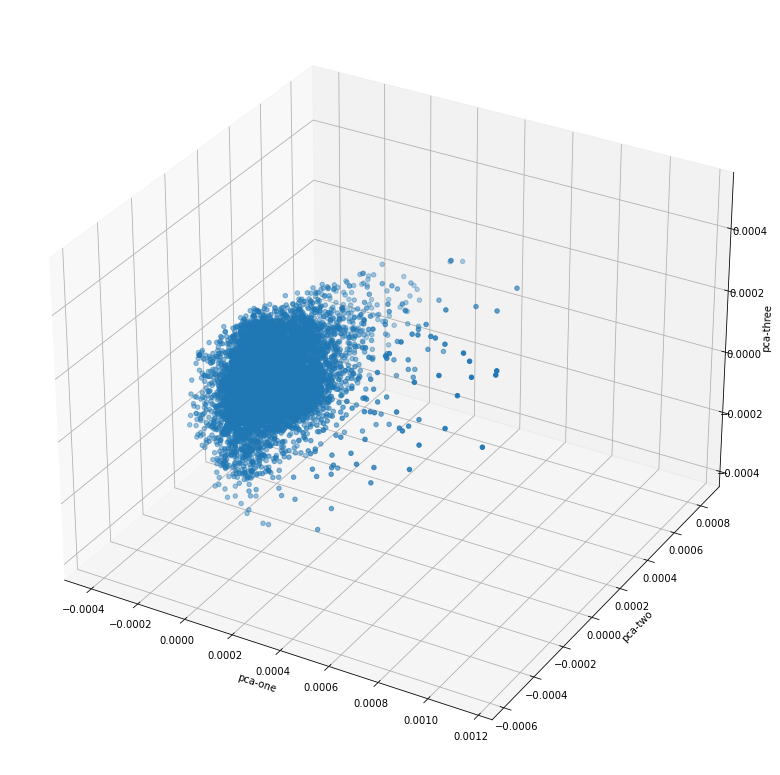

In [147]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Embeddings Graphsage for **Basal** tumors (113 patients)

In [60]:
basalExprMatrixShort = basalExprMatrix.iloc[:,:controlsDK.shape[1]]
directedGraphTumorBasal = sg.StellarDiGraph(basalExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumorBasal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [61]:
batch_sizeTumor = int(tumorDKfinal.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [62]:
generatorTumorBasal = DirectedGraphSAGENodeGenerator(directedGraphTumorBasal, batch_sizeTumor, in_samples, out_samples)

In [63]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorBasal.flow(tumorDKfinal.index, tumorDKfinal)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorBasal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=basalExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [64]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [65]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [66]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0321 - acc: 0.0100 - 19s/epoch - 19s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0293 - acc: 0.0087 - 19s/epoch - 19s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 19s - loss: 0.0253 - acc: 0.0094 - 19s/epoch - 19s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 18s - loss: 0.0259 - acc: 0.0095 - 18s/epoch - 18s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 16s - loss: 0.0221 - acc: 0.0089 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 17s - loss: 0.0209 - acc: 0.0089 - 17s/epoch - 17s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesBasal113.ckpt
1/1 - 17s - 

In [67]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

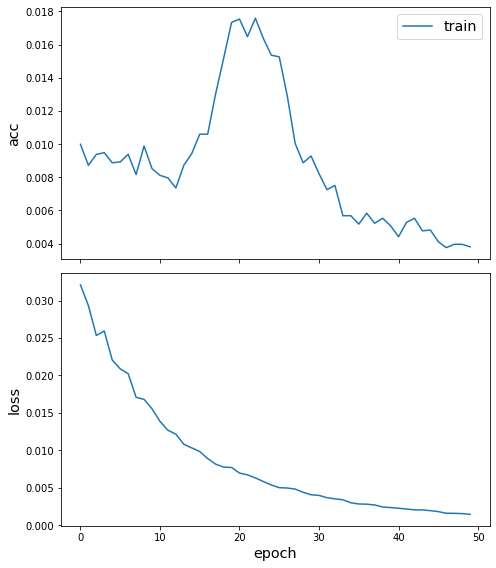

In [68]:
sg.utils.plot_history(history)

### generazione embedding per tumor Basal

In [69]:
all_mapper = generatorTumorBasal.flow(basalExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorBasal = pd.DataFrame(all_predictions, index =basalExprMatrix.index)

In [70]:
genesEmbeddingsTumorBasal

0         1         2         3         4         5         6    \
2      0.009878  0.009946  0.009992  0.007811  0.009308  0.009567  0.008053   
3      0.009842  0.009957  0.009904  0.007829  0.009282  0.009592  0.008146   
7      0.009919  0.009968  0.009912  0.007793  0.009313  0.009579  0.008115   
8      0.009920  0.009974  0.009926  0.007781  0.009317  0.009591  0.008116   
10     0.009860  0.009968  0.009970  0.007817  0.009340  0.009532  0.008068   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.009879  0.009999  0.010037  0.007813  0.009289  0.009471  0.008228   
20527  0.009893  0.009976  0.009891  0.007812  0.009309  0.009592  0.008119   
20528  0.009845  0.009968  0.009967  0.007832  0.009334  0.009514  0.008096   
20529  0.009902  0.009962  0.009889  0.007811  0.009305  0.009595  0.008097   
20530  0.009867  0.009980  0.009856  0.007844  0.009301  0.009607  0.008100   

            7         8         9    ...       103       104       105  \
2      0.007482  0.010204  0.009349  ...  0.007831  0.009248  0.007815   
3      0.007530  0.010194  0.009336  ...  0.007875  0.009301  0.007835   
7      0.007509  0.010171  0.009366  ...  0.007818  0.009317  0.007773   
8      0.007481  0.010195  0.009360  ...  0.007851  0.009292  0.007795   
10     0.007461  0.010230  0.009372  ...  0.007911  0.009306  0.007831   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007446  0.010254  0.009304  ...  0.007924  0.009312  0.007801   
20527  0.007519  0.010186  0.009363  ...  0.007823  0.009307  0.007808   
20528  0.007472  0.010259  0.009416  ...  0.007878  0.009264  0.007819   
20529  0.007545  0.010169  0.009369  ...  0.007822  0.009313  0.007794   
20530  0.007538  0.010182  0.009381  ...  0.007807  0.009308  0.007802   

            106       107       108       109       110       111       112  
2      0.009272  0.008081  0.010208  0.008457  0.010067  0.007582  0.010047  
3      0.009291  0.008158  0.010078  0.008508  0.010022  0.007637  0.010042  
7      0.009327  0.008133  0.010068  0.008484  0.010069  0.007659  0.010030  
8      0.009355  0.008106  0.010075  0.008488  0.010044  0.007657  0.010028  
10     0.009334  0.008086  0.010115  0.008498  0.010079  0.007615  0.010095  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009291  0.008134  0.010057  0.008514  0.010019  0.007602  0.010057  
20527  0.009283  0.008143  0.010081  0.008497  0.010078  0.007636  0.010030  
20528  0.009255  0.008167  0.010101  0.008508  0.010111  0.007558  0.010056  
20529  0.009309  0.008142  0.010077  0.008492  0.010072  0.007658  0.010029  
20530  0.009253  0.008150  0.010090  0.008504  0.010108  0.007600  0.010041  

[19727 rows x 113 columns]

### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

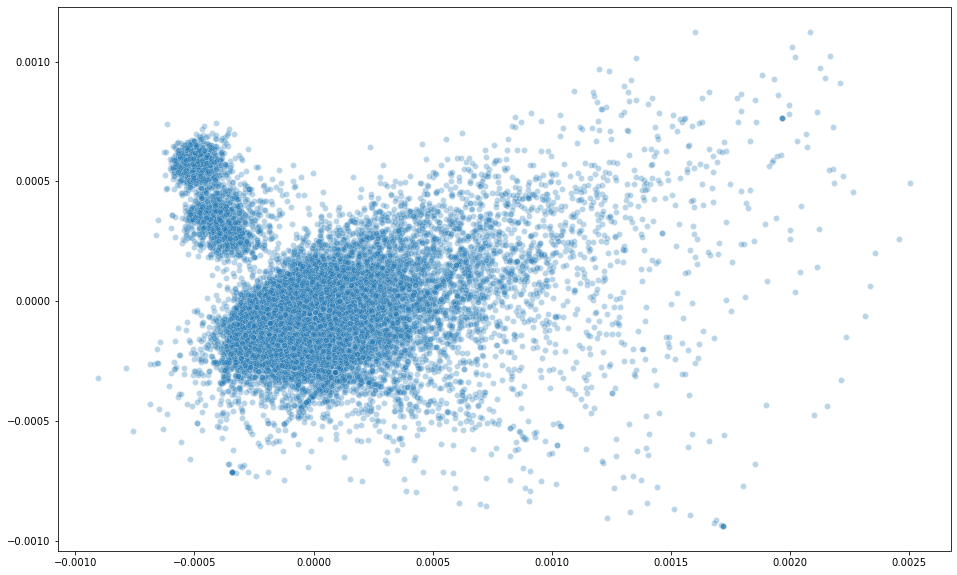

In [71]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorBasal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

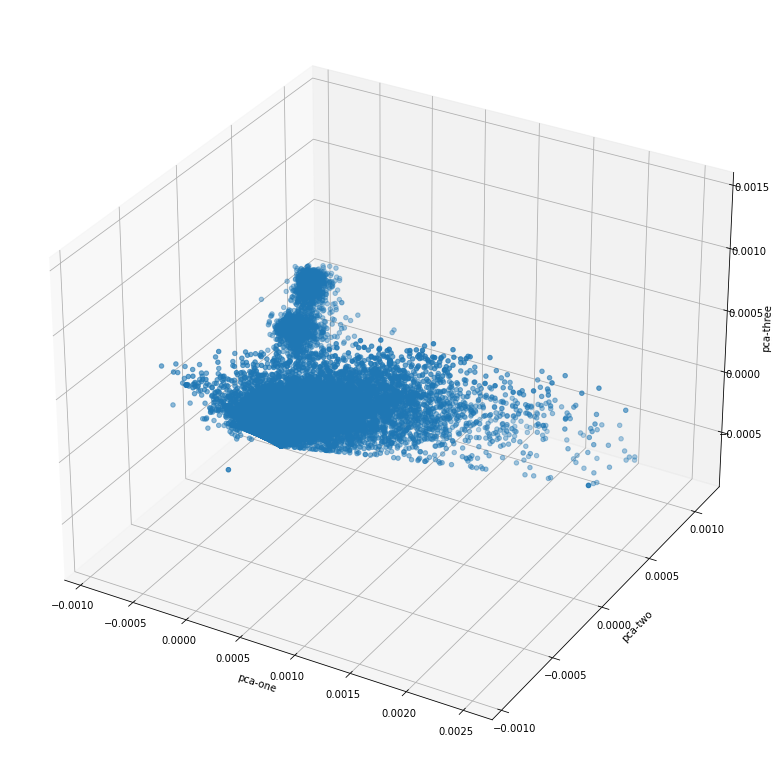

In [72]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumA** tumors

In [73]:
lumAExprMatrixShort = lumAExprMatrix.sample(n=basalExprMatrixShort.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumAExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [74]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [75]:
generatorTumorLumA = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [76]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumA.flow(lumAExprMatrixShort.index, lumAExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumA, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumAExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [77]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [79]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [80]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 17s - loss: 0.0337 - acc: 0.0076 - 17s/epoch - 17s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 16s - loss: 0.0335 - acc: 0.0097 - 16s/epoch - 16s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 16s - loss: 0.0285 - acc: 0.0090 - 16s/epoch - 16s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 18s - loss: 0.0252 - acc: 0.0082 - 18s/epoch - 18s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 20s - loss: 0.0239 - acc: 0.0085 - 20s/epoch - 20s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 - 20s - loss: 0.0215 - acc: 0.0075 - 20s/epoch - 20s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAShort.ckpt
1/1 -

In [81]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

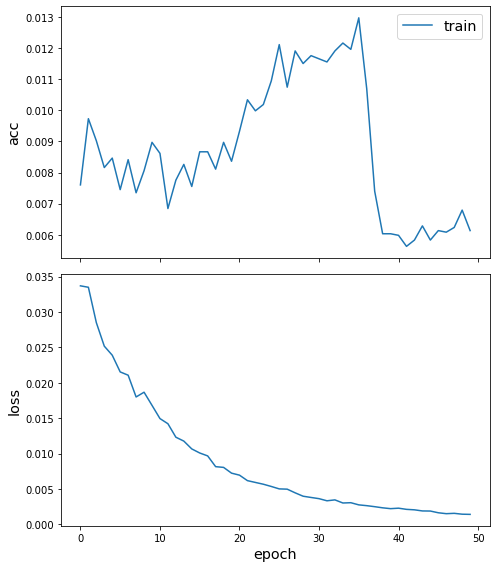

In [82]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumA

In [83]:
all_mapper = generatorTumorLumA.flow(lumAExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA = pd.DataFrame(all_predictions, index =lumAExprMatrixShort.index,columns =lumAExprMatrixShort.columns)

In [84]:
genesEmbeddingsTumorLumA

TCGA-E9-A1N4  TCGA-BH-A0B5  TCGA-C8-A273  TCGA-AR-A24T  TCGA-E9-A229  \
2          0.007776      0.008306      0.010091      0.009965      0.009812   
3          0.007874      0.008274      0.010160      0.009925      0.009824   
7          0.007804      0.008252      0.010091      0.009956      0.009855   
8          0.007824      0.008215      0.010088      0.009966      0.009843   
10         0.007822      0.008201      0.010088      0.009961      0.009843   
...             ...           ...           ...           ...           ...   
20526      0.007838      0.008162      0.010587      0.010033      0.009856   
20527      0.007836      0.008210      0.010095      0.009954      0.009835   
20528      0.007839      0.008212      0.010074      0.009958      0.009831   
20529      0.007825      0.008249      0.010127      0.009961      0.009849   
20530      0.007823      0.008240      0.010125      0.009955      0.009855   

       TCGA-E9-A245  TCGA-4H-AAAK  TCGA-AR-A0TW  TCGA-D8-A4Z1  TCGA-BH-A1FG  \
2          0.007835      0.009566      0.008450      0.008115      0.008514   
3          0.007807      0.009602      0.008594      0.008329      0.008302   
7          0.007742      0.009620      0.008464      0.008166      0.008371   
8          0.007775      0.009621      0.008511      0.008175      0.008403   
10         0.007764      0.009618      0.008508      0.008151      0.008405   
...             ...           ...           ...           ...           ...   
20526      0.007605      0.009502      0.008600      0.008129      0.008243   
20527      0.007783      0.009617      0.008529      0.008186      0.008393   
20528      0.007808      0.009609      0.008522      0.008203      0.008410   
20529      0.007753      0.009626      0.008523      0.008193      0.008362   
20530      0.007733      0.009644      0.008528      0.008191      0.008344   

       ...  TCGA-E2-A1IE  TCGA-OL-A66L  TCGA-A1-A0SH  TCGA-AR-A24V  \
2      ...      0.008447      0.008229      0.009891      0.009479   
3      ...      0.008350      0.008152      0.009959      0.009577   
7      ...      0.008491      0.008189      0.009796      0.009546   
8      ...      0.008425      0.008175      0.009820      0.009540   
10     ...      0.008436      0.008180      0.009809      0.009538   
...    ...           ...           ...           ...           ...   
20526  ...      0.008537      0.008085      0.009777      0.009570   
20527  ...      0.008408      0.008178      0.009843      0.009546   
20528  ...      0.008400      0.008189      0.009849      0.009519   
20529  ...      0.008423      0.008158      0.009847      0.009583   
20530  ...      0.008433      0.008138      0.009827      0.009599   

       TCGA-D8-A1JS  TCGA-E2-A105  TCGA-AC-A8OP  TCGA-B6-A0IC  TCGA-AQ-A0Y5  \
2          0.008170      0.009408      0.007581      0.008513      0.010225   
3          0.008199      0.009360      0.007467      0.008464      0.010236   
7          0.008178      0.009366      0.007491      0.008508      0.010152   
8          0.008202      0.009365      0.007558      0.008447      0.010207   
10         0.008219      0.009373      0.007578      0.008437      0.010205   
...             ...           ...           ...           ...           ...   
20526      0.008351      0.009394      0.007616      0.008649      0.010194   
20527      0.008215      0.009366      0.007567      0.008426      0.010220   
20528      0.008189      0.009365      0.007541      0.008441      0.010211   
20529      0.008204      0.009371      0.007535      0.008448      0.010210   
20530      0.008230      0.009359      0.007560      0.008446      0.010212   

       TCGA-E2-A15O  
2          0.009820  
3          0.009646  
7          0.009663  
8          0.009686  
10         0.009702  
...             ...  
20526      0.009538  
20527      0.009701  
20528      0.009692  
20529      0.009681  
20530      0.009668  

[19727 rows x 113 columns]

### visualizzazione embeddings LumA

<AxesSubplot:>

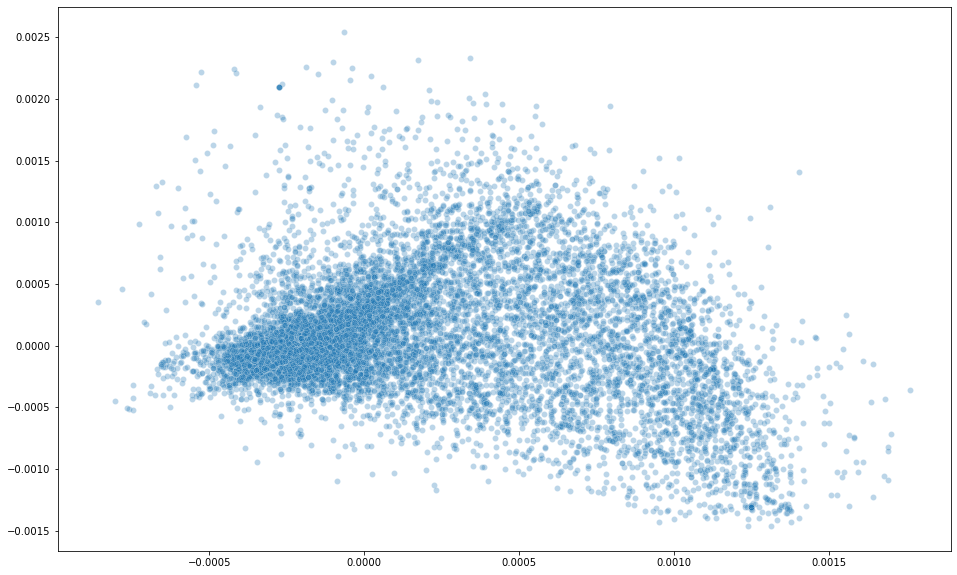

In [85]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumA)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

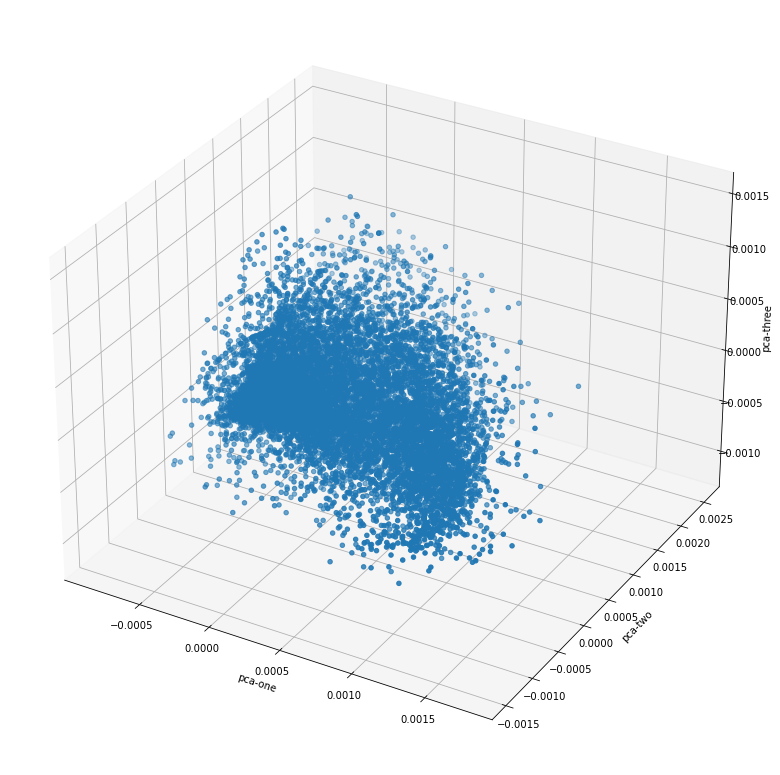

In [86]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumB** tumors

In [45]:
lumBExprMatrixShort = lumBExprMatrix.sample(n=basalExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumBExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 171
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [46]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [47]:
generatorTumorLumB = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [48]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumB.flow(lumBExprMatrixShort.index, lumBExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumA, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumBExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [49]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 5, 171)]     0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 10, 171)]    0           []                               
                                                                                            

In [70]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [51]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 22s - loss: 50.9650 - acc: 0.0058 - 22s/epoch - 22s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 21s - loss: 46.8986 - acc: 0.0065 - 21s/epoch - 21s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 20s - loss: 42.3280 - acc: 0.0054 - 20s/epoch - 20s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 18s - loss: 37.2049 - acc: 0.0055 - 18s/epoch - 18s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 19s - loss: 34.5947 - acc: 0.0065 - 19s/epoch - 19s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 18s - loss: 30.6868 - acc: 0.0065 - 18s/epoch - 18s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumB.ckpt
1/1 - 18s - loss: 27.0939 - acc: 0

In [52]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

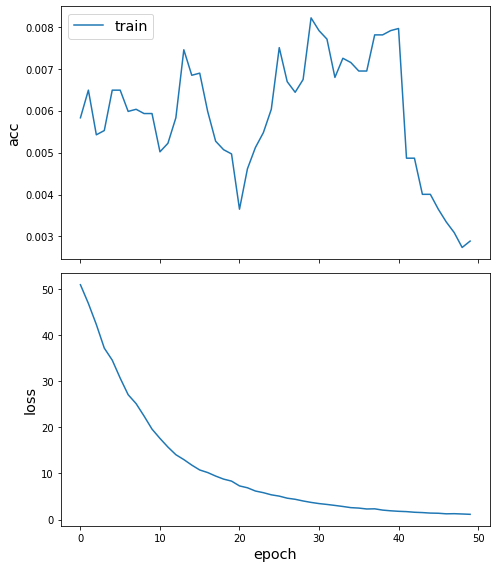

In [53]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumB

In [71]:
all_mapper = generatorTumorLumB.flow(lumBExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumB = pd.DataFrame(all_predictions, index =lumBExprMatrixShort.index,columns =lumBExprMatrixShort.columns)

In [72]:
genesEmbeddingsTumorLumB

TCGA-BH-A1FJ  TCGA-A8-A06R  TCGA-E9-A249  TCGA-E9-A1NA  TCGA-EW-A2FW  \
2          0.004976      0.006105      0.005124      0.006401      0.006509   
3          0.004956      0.006155      0.005104      0.006409      0.006514   
7          0.004959      0.006143      0.005095      0.006414      0.006537   
8          0.004960      0.006145      0.005095      0.006414      0.006535   
10         0.004958      0.006150      0.005097      0.006413      0.006529   
...             ...           ...           ...           ...           ...   
20526      0.004995      0.006148      0.005112      0.006423      0.006552   
20527      0.004960      0.006144      0.005095      0.006414      0.006536   
20528      0.004960      0.006144      0.005095      0.006414      0.006537   
20529      0.004964      0.006144      0.005098      0.006414      0.006536   
20530      0.004962      0.006142      0.005095      0.006413      0.006541   

       TCGA-AR-A250  TCGA-A2-A0SW  TCGA-AC-A7VB  TCGA-BH-A202  TCGA-A8-A07L  \
2          0.005012      0.006533      0.005833      0.004993      0.004943   
3          0.005061      0.006502      0.005845      0.005020      0.004974   
7          0.005015      0.006511      0.005815      0.004997      0.004948   
8          0.005012      0.006513      0.005813      0.004996      0.004949   
10         0.005021      0.006506      0.005824      0.005003      0.004953   
...             ...           ...           ...           ...           ...   
20526      0.005020      0.006489      0.005865      0.005046      0.004923   
20527      0.005012      0.006513      0.005813      0.004996      0.004948   
20528      0.005012      0.006512      0.005814      0.004997      0.004948   
20529      0.005008      0.006509      0.005814      0.005000      0.004942   
20530      0.005012      0.006513      0.005816      0.004999      0.004939   

       ...  TCGA-C8-A130  TCGA-EW-A1OX  TCGA-A8-A09I  TCGA-B6-A0IN  \
2      ...      0.004959      0.005322      0.006580      0.005129   
3      ...      0.004987      0.005359      0.006559      0.005134   
7      ...      0.004941      0.005344      0.006580      0.005139   
8      ...      0.004941      0.005342      0.006581      0.005140   
10     ...      0.004952      0.005344      0.006574      0.005134   
...    ...           ...           ...           ...           ...   
20526  ...      0.005000      0.005379      0.006566      0.005079   
20527  ...      0.004941      0.005342      0.006580      0.005139   
20528  ...      0.004941      0.005343      0.006580      0.005139   
20529  ...      0.004946      0.005345      0.006580      0.005134   
20530  ...      0.004940      0.005346      0.006577      0.005132   

       TCGA-AO-A1KP  TCGA-AO-A0JD  TCGA-E9-A2JS  TCGA-AN-A0AM  TCGA-A8-A076  \
2          0.006787      0.005180      0.006327      0.005682      0.006623   
3          0.006817      0.005192      0.006309      0.005683      0.006600   
7          0.006778      0.005147      0.006351      0.005683      0.006614   
8          0.006778      0.005149      0.006353      0.005685      0.006614   
10         0.006789      0.005156      0.006340      0.005685      0.006607   
...             ...           ...           ...           ...           ...   
20526      0.006797      0.005148      0.006328      0.005660      0.006594   
20527      0.006778      0.005148      0.006353      0.005685      0.006614   
20528      0.006778      0.005147      0.006353      0.005684      0.006614   
20529      0.006777      0.005147      0.006355      0.005682      0.006612   
20530      0.006777      0.005141      0.006357      0.005684      0.006617   

       TCGA-A8-A082  
2          0.006579  
3          0.006610  
7          0.006594  
8          0.006592  
10         0.006596  
...             ...  
20526      0.006599  
20527      0.006592  
20528      0.006593  
20529      0.006591  
20530      0.006589  

[19727 rows x 171 columns]

### visualizzazione embeddings LumB

<AxesSubplot:>

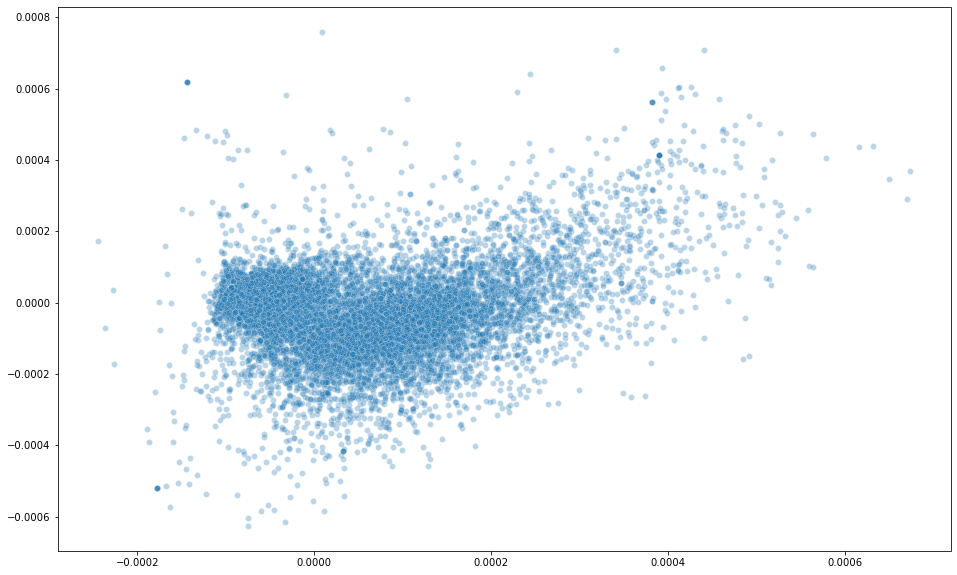

In [73]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumB)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

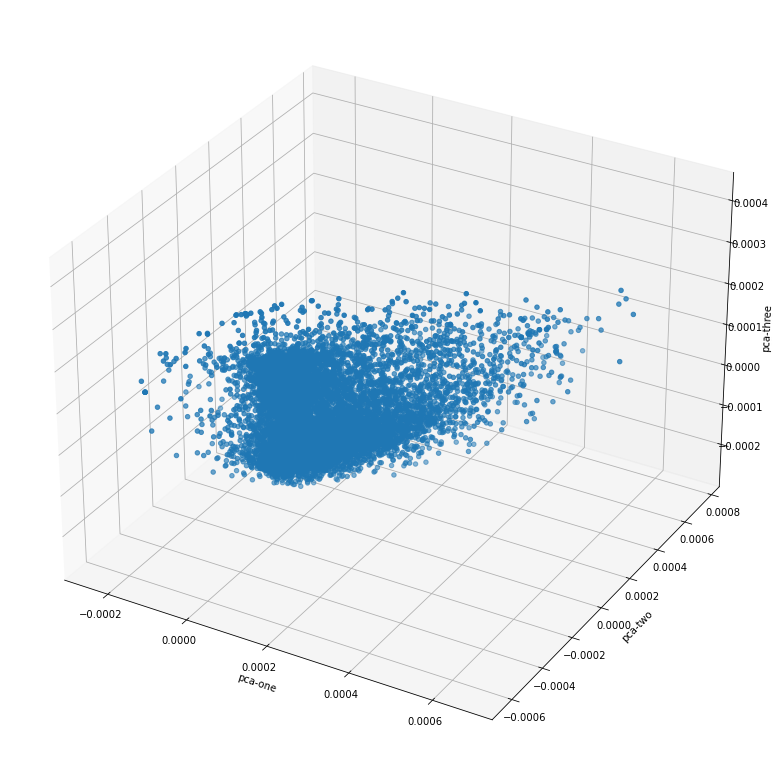

In [74]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumB** tumors (113 patients)

In [87]:
lumBExprMatrixShort = lumBExprMatrix.sample(n=basalExprMatrixShort.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(lumBExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [88]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [89]:
generatorTumorLumB = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [90]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorLumB.flow(lumBExprMatrixShort.index, lumBExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumA, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumBExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [91]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [93]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [94]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 17s - loss: 0.0327 - acc: 0.0104 - 17s/epoch - 17s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0273 - acc: 0.0094 - 16s/epoch - 16s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0256 - acc: 0.0094 - 16s/epoch - 16s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0227 - acc: 0.0108 - 16s/epoch - 16s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 16s - loss: 0.0215 - acc: 0.0101 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 - 17s - loss: 0.0192 - acc: 0.0104 - 17s/epoch - 17s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBShort.ckpt
1/1 -

In [95]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

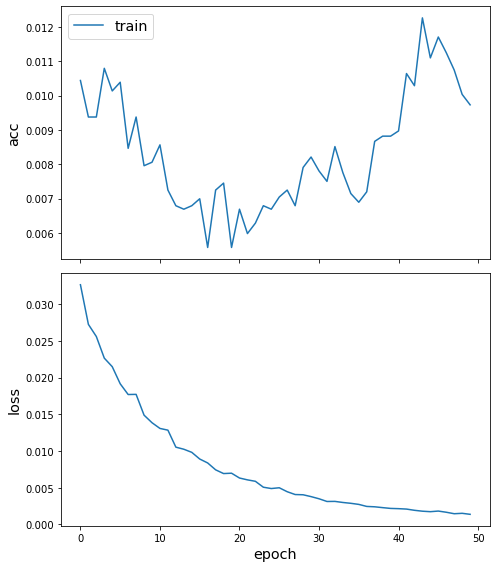

In [96]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumB

In [99]:
all_mapper = generatorTumorLumB.flow(lumBExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumB = pd.DataFrame(all_predictions, index =lumBExprMatrixShort.index)

In [100]:
genesEmbeddingsTumorLumB

0         1         2         3         4         5         6    \
2      0.007662  0.007989  0.008272  0.009933  0.008244  0.008182  0.009054   
3      0.007791  0.008557  0.008288  0.009876  0.008135  0.008195  0.009451   
7      0.007645  0.007989  0.008264  0.009975  0.008255  0.008254  0.009070   
8      0.007646  0.008000  0.008267  0.009966  0.008250  0.008249  0.009071   
10     0.007584  0.007966  0.008227  0.009936  0.008265  0.008228  0.009040   
...         ...       ...       ...       ...       ...       ...       ...   
20526  0.007872  0.008506  0.008549  0.010014  0.007931  0.008465  0.009186   
20527  0.007658  0.008000  0.008266  0.009967  0.008242  0.008243  0.009059   
20528  0.007646  0.007991  0.008265  0.009964  0.008250  0.008248  0.009069   
20529  0.007655  0.008000  0.008262  0.009976  0.008255  0.008259  0.009077   
20530  0.007638  0.007996  0.008274  0.009968  0.008244  0.008237  0.009042   

            7         8         9    ...       103       104       105  \
2      0.007542  0.009585  0.009102  ...  0.008197  0.009039  0.010126   
3      0.007380  0.009711  0.009427  ...  0.008447  0.008968  0.009950   
7      0.007580  0.009605  0.009158  ...  0.008204  0.009110  0.010159   
8      0.007585  0.009603  0.009165  ...  0.008205  0.009114  0.010159   
10     0.007536  0.009555  0.009132  ...  0.008229  0.009070  0.010155   
...         ...       ...       ...  ...       ...       ...       ...   
20526  0.007539  0.009834  0.009341  ...  0.008314  0.009300  0.010130   
20527  0.007592  0.009625  0.009170  ...  0.008189  0.009119  0.010157   
20528  0.007587  0.009603  0.009163  ...  0.008204  0.009111  0.010154   
20529  0.007579  0.009602  0.009162  ...  0.008199  0.009112  0.010160   
20530  0.007586  0.009608  0.009171  ...  0.008196  0.009118  0.010172   

            106       107       108       109       110       111       112  
2      0.009440  0.007211  0.007682  0.008358  0.008610  0.009606  0.009687  
3      0.009221  0.007402  0.007641  0.008289  0.008343  0.009719  0.009797  
7      0.009407  0.007247  0.007667  0.008299  0.008639  0.009599  0.009732  
8      0.009405  0.007251  0.007667  0.008297  0.008639  0.009605  0.009731  
10     0.009408  0.007266  0.007668  0.008251  0.008653  0.009622  0.009731  
...         ...       ...       ...       ...       ...       ...       ...  
20526  0.009455  0.007289  0.007600  0.008517  0.008622  0.009604  0.009768  
20527  0.009415  0.007246  0.007682  0.008303  0.008633  0.009607  0.009730  
20528  0.009403  0.007256  0.007658  0.008294  0.008636  0.009608  0.009730  
20529  0.009414  0.007238  0.007680  0.008304  0.008643  0.009595  0.009732  
20530  0.009420  0.007239  0.007688  0.008295  0.008650  0.009601  0.009735  

[19727 rows x 113 columns]

### visualizzazione embeddings LumB

<AxesSubplot:>

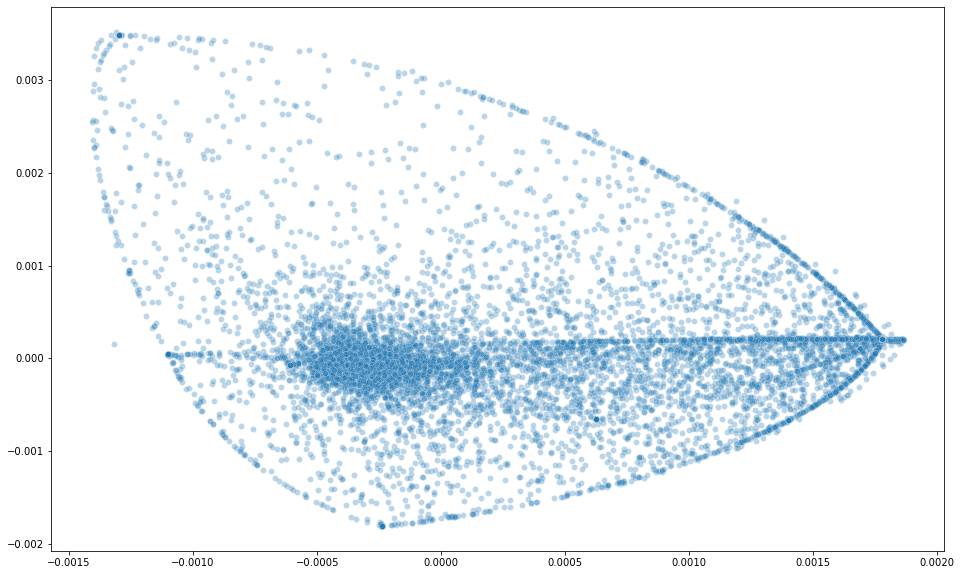

In [101]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumB)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

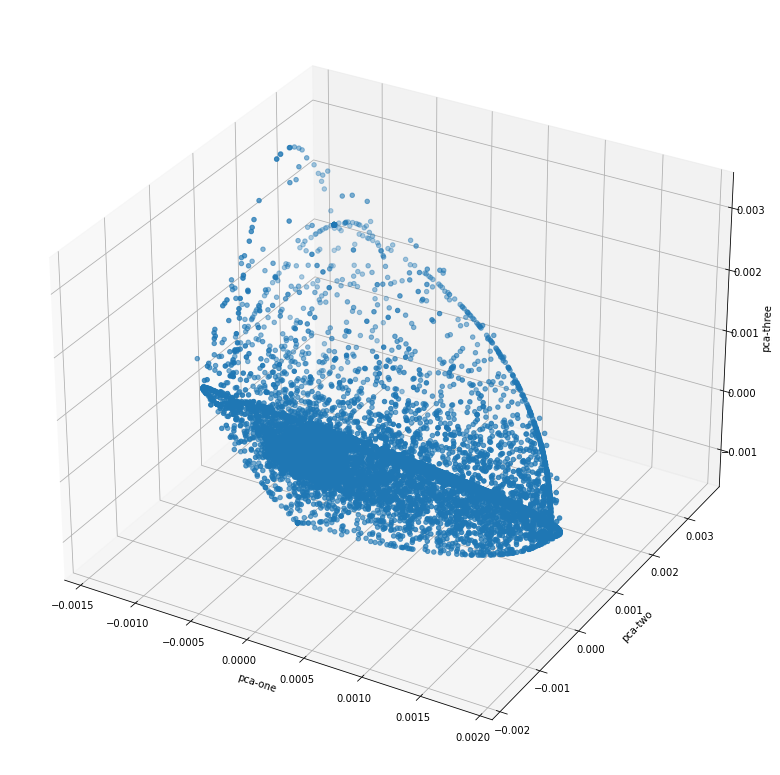

In [102]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage I** tumors

In [75]:
#stageExprMatrixShort = stageIExprMatrix.sample(n=basalExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIExprMatrix ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [76]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [77]:
generatorTumorStageI = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [79]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageI.flow(stageIExprMatrix.index, stageIExprMatrix)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageI, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [80]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [81]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [82]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 23s - loss: 49.2279 - acc: 0.0025 - 23s/epoch - 23s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 45.1349 - acc: 0.0029 - 22s/epoch - 22s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 40.8627 - acc: 0.0030 - 22s/epoch - 22s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 36.7535 - acc: 0.0035 - 22s/epoch - 22s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 32.1572 - acc: 0.0031 - 22s/epoch - 22s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 21s - loss: 29.9125 - acc: 0.0033 - 21s/epoch - 21s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageI.ckpt
1/1 - 22s - loss: 25

In [83]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

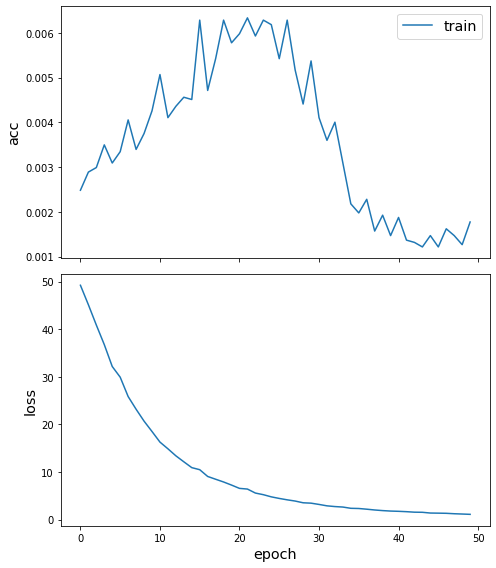

In [84]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage I

In [85]:
all_mapper = generatorTumorStageI.flow(stageIExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageI = pd.DataFrame(all_predictions, index =stageIExprMatrix.index,columns =stageIExprMatrix.columns)

In [86]:
genesEmbeddingsTumorStageI

TCGA-3C-AALK  TCGA-A1-A0SB  TCGA-A1-A0SE  TCGA-A2-A04N  TCGA-A2-A04Q  \
2          0.004746      0.006207      0.004781      0.005088      0.005704   
3          0.004747      0.006178      0.004800      0.005047      0.005712   
7          0.004760      0.006199      0.004763      0.005077      0.005688   
8          0.004760      0.006200      0.004765      0.005077      0.005687   
10         0.004761      0.006201      0.004767      0.005075      0.005686   
...             ...           ...           ...           ...           ...   
20526      0.004759      0.006206      0.004790      0.005069      0.005675   
20527      0.004759      0.006199      0.004765      0.005077      0.005688   
20528      0.004761      0.006200      0.004765      0.005076      0.005687   
20529      0.004760      0.006200      0.004765      0.005076      0.005687   
20530      0.004760      0.006199      0.004762      0.005078      0.005688   

       TCGA-A2-A04R  TCGA-A2-A0CP  TCGA-A2-A0CQ  TCGA-A2-A0D3  TCGA-A2-A0EM  \
2          0.005695      0.006119      0.006064      0.005557      0.006263   
3          0.005639      0.006134      0.006062      0.005538      0.006246   
7          0.005687      0.006113      0.006046      0.005554      0.006244   
8          0.005687      0.006113      0.006046      0.005554      0.006243   
10         0.005686      0.006113      0.006047      0.005554      0.006243   
...             ...           ...           ...           ...           ...   
20526      0.005686      0.006118      0.006055      0.005542      0.006249   
20527      0.005687      0.006113      0.006047      0.005553      0.006243   
20528      0.005686      0.006112      0.006046      0.005553      0.006244   
20529      0.005687      0.006111      0.006046      0.005553      0.006243   
20530      0.005688      0.006112      0.006046      0.005554      0.006244   

       ...  TCGA-OL-A5RX  TCGA-OL-A5RZ  TCGA-OL-A66H  TCGA-OL-A66J  \
2      ...      0.004899      0.004439      0.006279      0.004539   
3      ...      0.004881      0.004453      0.006333      0.004518   
7      ...      0.004881      0.004440      0.006301      0.004501   
8      ...      0.004879      0.004441      0.006302      0.004501   
10     ...      0.004880      0.004446      0.006304      0.004501   
...    ...           ...           ...           ...           ...   
20526  ...      0.004885      0.004445      0.006291      0.004519   
20527  ...      0.004880      0.004439      0.006302      0.004501   
20528  ...      0.004880      0.004443      0.006304      0.004503   
20529  ...      0.004880      0.004440      0.006302      0.004501   
20530  ...      0.004879      0.004439      0.006301      0.004503   

       TCGA-OL-A66L  TCGA-OL-A6VO  TCGA-OL-A6VR  TCGA-S3-AA14  TCGA-WT-AB44  \
2          0.005144      0.006103      0.005682      0.004735      0.004795   
3          0.005119      0.006109      0.005677      0.004728      0.004801   
7          0.005129      0.006118      0.005679      0.004770      0.004783   
8          0.005129      0.006118      0.005679      0.004771      0.004783   
10         0.005130      0.006118      0.005679      0.004770      0.004784   
...             ...           ...           ...           ...           ...   
20526      0.005121      0.006115      0.005674      0.004724      0.004795   
20527      0.005129      0.006117      0.005679      0.004770      0.004783   
20528      0.005129      0.006117      0.005680      0.004770      0.004784   
20529      0.005128      0.006118      0.005680      0.004771      0.004783   
20530      0.005129      0.006117      0.005679      0.004770      0.004782   

       TCGA-Z7-A8R6  
2          0.004928  
3          0.004935  
7          0.004930  
8          0.004930  
10         0.004928  
...             ...  
20526      0.004933  
20527      0.004930  
20528      0.004929  
20529      0.004930  
20530      0.004931  

[19727 rows x 180 columns]

### visualizzazione embeddings StageI

<AxesSubplot:>

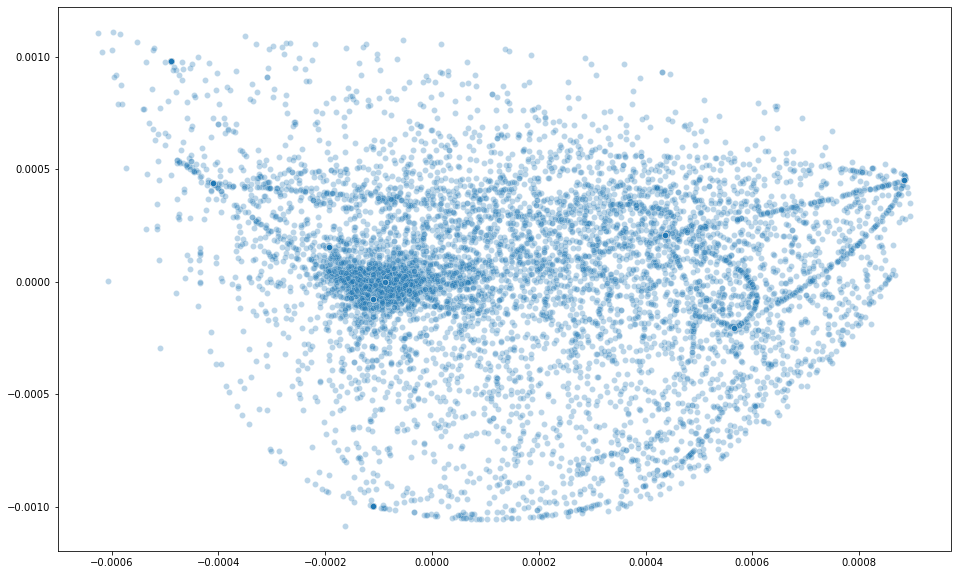

In [87]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageI)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

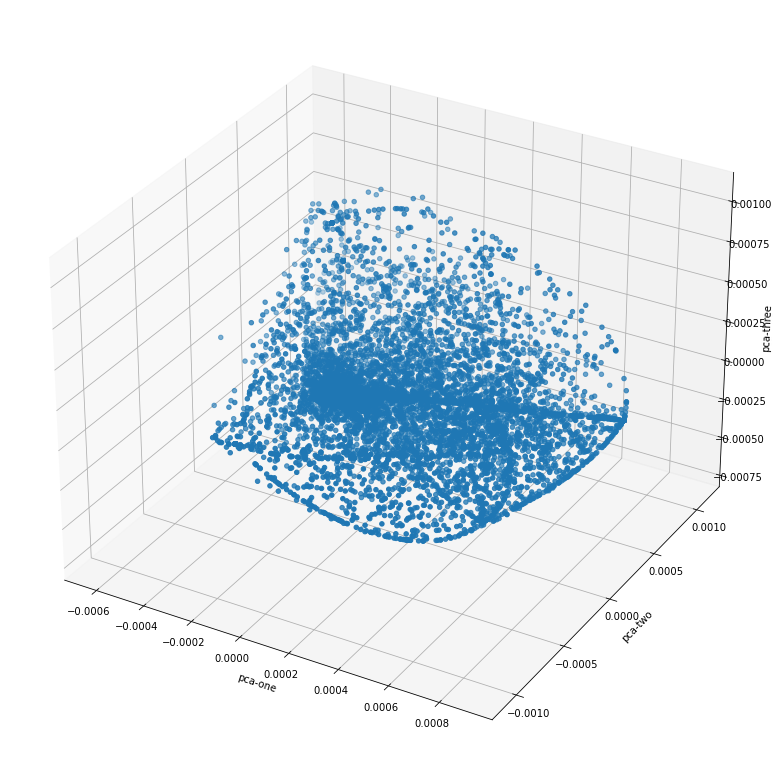

In [88]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage II** tumors

In [89]:
stageIIExprMatrixShort = stageIIExprMatrix.sample(n=stageIExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIIExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [90]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [91]:
generatorTumorStageII = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [92]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageII.flow(stageIIExprMatrixShort.index, stageIIExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageII, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)


In [93]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [94]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [95]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 24s - loss: 53.4809 - acc: 0.0057 - 24s/epoch - 24s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 21s - loss: 48.4542 - acc: 0.0085 - 21s/epoch - 21s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 21s - loss: 42.3013 - acc: 0.0075 - 21s/epoch - 21s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 19s - loss: 38.4755 - acc: 0.0055 - 19s/epoch - 19s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 20s - loss: 34.0123 - acc: 0.0055 - 20s/epoch - 20s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 18s - loss: 29.9842 - acc: 0.0061 - 18s/epoch - 18s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageII.ckpt
1/1 - 19s - l

In [96]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

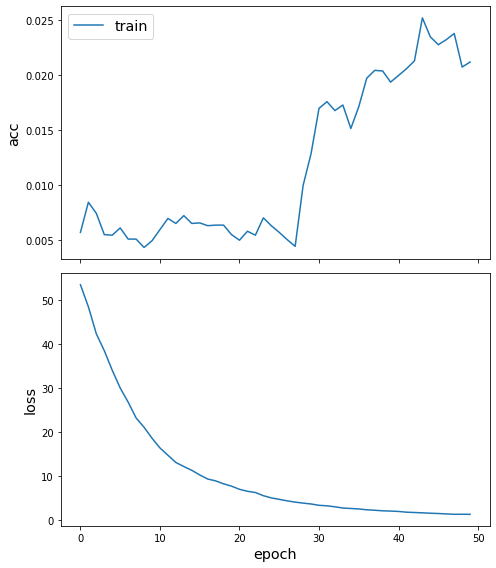

In [97]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage II

In [99]:
all_mapper = generatorTumorStageII.flow(stageIIExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageII = pd.DataFrame(all_predictions, index =stageIIExprMatrixShort.index,columns =stageIIExprMatrixShort.columns)

In [100]:
genesEmbeddingsTumorStageII

TCGA-E2-A1B5  TCGA-OL-A5RW  TCGA-AR-A2LO  TCGA-A7-A26I  TCGA-A8-A07C  \
2          0.005634      0.005906      0.006169      0.006265      0.005645   
3          0.005540      0.005919      0.006175      0.006259      0.005799   
7          0.005627      0.005926      0.006155      0.006272      0.005649   
8          0.005628      0.005927      0.006157      0.006272      0.005651   
10         0.005634      0.005925      0.006165      0.006269      0.005651   
...             ...           ...           ...           ...           ...   
20526      0.005589      0.005967      0.006270      0.006218      0.005783   
20527      0.005627      0.005927      0.006156      0.006272      0.005652   
20528      0.005625      0.005928      0.006157      0.006271      0.005654   
20529      0.005628      0.005926      0.006157      0.006272      0.005651   
20530      0.005630      0.005927      0.006158      0.006272      0.005650   

       TCGA-D8-A1JK  TCGA-E9-A1N5  TCGA-WT-AB41  TCGA-AO-A125  TCGA-D8-A1JM  \
2          0.005056      0.006111      0.005749      0.005793      0.005721   
3          0.005003      0.006100      0.005725      0.005854      0.005677   
7          0.005064      0.006096      0.005764      0.005791      0.005714   
8          0.005067      0.006093      0.005772      0.005784      0.005712   
10         0.005071      0.006094      0.005780      0.005781      0.005710   
...             ...           ...           ...           ...           ...   
20526      0.005076      0.006074      0.005797      0.005745      0.005628   
20527      0.005065      0.006093      0.005769      0.005786      0.005712   
20528      0.005066      0.006093      0.005770      0.005785      0.005712   
20529      0.005066      0.006093      0.005772      0.005784      0.005712   
20530      0.005067      0.006092      0.005773      0.005783      0.005712   

       ...  TCGA-A2-A0T0  TCGA-D8-A1XF  TCGA-A7-A56D  TCGA-D8-A27G  \
2      ...      0.005971      0.005806      0.006169      0.006246   
3      ...      0.005865      0.005756      0.006066      0.006196   
7      ...      0.005949      0.005803      0.006154      0.006259   
8      ...      0.005952      0.005805      0.006163      0.006260   
10     ...      0.005949      0.005806      0.006163      0.006260   
...    ...           ...           ...           ...           ...   
20526  ...      0.005933      0.005779      0.006105      0.006159   
20527  ...      0.005951      0.005804      0.006160      0.006260   
20528  ...      0.005950      0.005804      0.006160      0.006260   
20529  ...      0.005951      0.005804      0.006162      0.006261   
20530  ...      0.005952      0.005805      0.006162      0.006261   

       TCGA-E2-A105  TCGA-A2-A0CR  TCGA-A1-A0SO  TCGA-LL-A5YL  TCGA-C8-A27A  \
2          0.004632      0.005443      0.005809      0.006183      0.004711   
3          0.004705      0.005404      0.005835      0.006198      0.004811   
7          0.004635      0.005432      0.005802      0.006187      0.004724   
8          0.004641      0.005436      0.005797      0.006189      0.004727   
10         0.004634      0.005438      0.005794      0.006190      0.004722   
...             ...           ...           ...           ...           ...   
20526      0.004684      0.005461      0.005779      0.006248      0.004891   
20527      0.004640      0.005435      0.005799      0.006188      0.004727   
20528      0.004639      0.005434      0.005799      0.006187      0.004726   
20529      0.004638      0.005435      0.005798      0.006188      0.004726   
20530      0.004636      0.005435      0.005797      0.006188      0.004726   

       TCGA-AC-A3TN  
2          0.006372  
3          0.006349  
7          0.006359  
8          0.006358  
10         0.006357  
...             ...  
20526      0.006381  
20527      0.006359  
20528      0.006358  
20529      0.006358  
20530      0.006359  

[19727 rows x 180 columns]

### visualizzazione embeddings StageII

<AxesSubplot:>

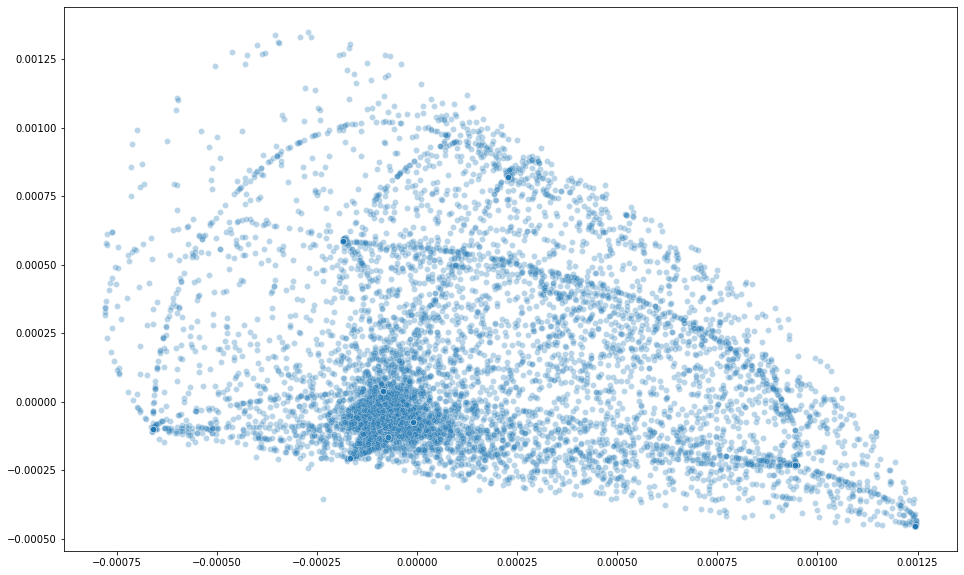

In [101]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageII)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

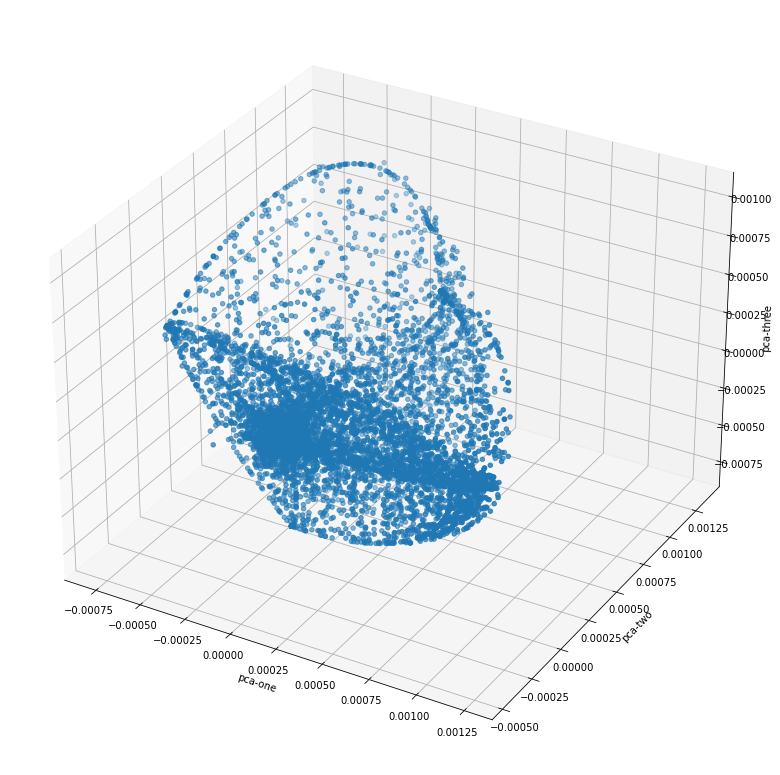

In [102]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage III** tumors

In [103]:
stageIIIExprMatrixShort = stageIIIExprMatrix.sample(n=stageIExprMatrix.shape[1], axis='columns', random_state=2)
directedGraphTumor = sg.StellarDiGraph(stageIIIExprMatrixShort ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 180
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [104]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [105]:
generatorTumorStageIII = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [106]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorStageIII.flow(stageIIIExprMatrixShort.index, stageIIIExprMatrixShort)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageIII, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIIIExprMatrixShort.shape[1], activation="softmax")(x_outTumorfinal)


In [107]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 5, 180)]     0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 10, 180)]    0           []                               
                                                                                            

In [108]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [109]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 23s - loss: 48.0094 - acc: 0.0051 - 23s/epoch - 23s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 23s - loss: 42.9409 - acc: 0.0062 - 23s/epoch - 23s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 22s - loss: 38.6943 - acc: 0.0056 - 22s/epoch - 22s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 20s - loss: 35.7220 - acc: 0.0063 - 20s/epoch - 20s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 22s - loss: 32.0655 - acc: 0.0062 - 22s/epoch - 22s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 24s - loss: 28.7676 - acc: 0.0070 - 24s/epoch - 24s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIII.ckpt
1/1 - 

In [110]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

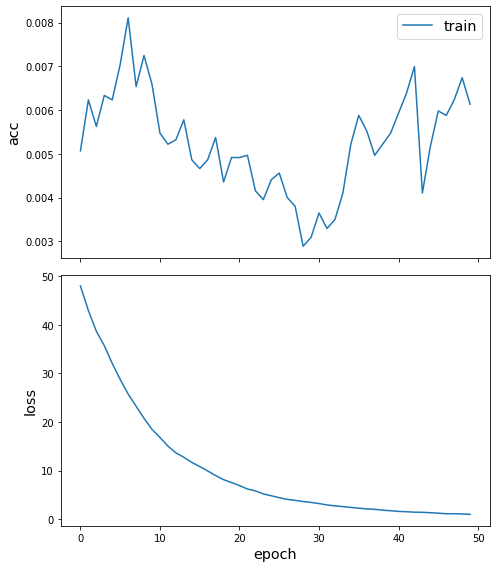

In [111]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage III

In [114]:
all_mapper = generatorTumorStageIII.flow(stageIIIExprMatrixShort.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageIII = pd.DataFrame(all_predictions, index =stageIIIExprMatrixShort.index,columns =stageIIIExprMatrixShort.columns)

In [115]:
genesEmbeddingsTumorStageIII

TCGA-D8-A27T  TCGA-AQ-A1H2  TCGA-C8-A8HR  TCGA-EW-A2FR  TCGA-AQ-A1H3  \
2          0.006219      0.006286      0.004875      0.006219      0.006301   
3          0.006216      0.006292      0.004871      0.006226      0.006292   
7          0.006215      0.006302      0.004885      0.006231      0.006301   
8          0.006219      0.006298      0.004881      0.006223      0.006303   
10         0.006217      0.006295      0.004885      0.006224      0.006297   
...             ...           ...           ...           ...           ...   
20526      0.006216      0.006314      0.004860      0.006224      0.006295   
20527      0.006219      0.006294      0.004878      0.006223      0.006306   
20528      0.006219      0.006291      0.004877      0.006220      0.006297   
20529      0.006218      0.006297      0.004881      0.006226      0.006306   
20530      0.006219      0.006299      0.004876      0.006225      0.006304   

       TCGA-GM-A3XG  TCGA-E9-A3Q9  TCGA-A7-A4SB  TCGA-A8-A06T  TCGA-AN-A0XR  \
2          0.004800      0.006168      0.004674      0.004827      0.004837   
3          0.004798      0.006164      0.004666      0.004816      0.004840   
7          0.004815      0.006158      0.004671      0.004822      0.004834   
8          0.004813      0.006165      0.004671      0.004823      0.004840   
10         0.004817      0.006162      0.004676      0.004821      0.004840   
...             ...           ...           ...           ...           ...   
20526      0.004797      0.006166      0.004679      0.004808      0.004833   
20527      0.004813      0.006170      0.004673      0.004823      0.004839   
20528      0.004811      0.006168      0.004674      0.004820      0.004845   
20529      0.004817      0.006168      0.004677      0.004825      0.004838   
20530      0.004810      0.006169      0.004676      0.004819      0.004839   

       ...  TCGA-A2-A25E  TCGA-AO-A0JL  TCGA-AN-A0FZ  TCGA-BH-A0DV  \
2      ...      0.006263      0.006279      0.006312      0.006041   
3      ...      0.006274      0.006271      0.006301      0.006033   
7      ...      0.006280      0.006275      0.006303      0.006044   
8      ...      0.006273      0.006276      0.006304      0.006043   
10     ...      0.006273      0.006277      0.006306      0.006040   
...    ...           ...           ...           ...           ...   
20526  ...      0.006262      0.006268      0.006310      0.006037   
20527  ...      0.006272      0.006278      0.006305      0.006042   
20528  ...      0.006266      0.006276      0.006305      0.006037   
20529  ...      0.006271      0.006278      0.006304      0.006044   
20530  ...      0.006269      0.006277      0.006307      0.006039   

       TCGA-AC-A3EH  TCGA-A8-A06Q  TCGA-A8-A07U  TCGA-BH-A0E0  TCGA-AN-A0XT  \
2          0.005373      0.004795      0.004719      0.005754      0.006057   
3          0.005366      0.004796      0.004722      0.005760      0.006064   
7          0.005378      0.004803      0.004727      0.005754      0.006062   
8          0.005371      0.004797      0.004723      0.005759      0.006063   
10         0.005373      0.004799      0.004718      0.005756      0.006064   
...             ...           ...           ...           ...           ...   
20526      0.005367      0.004772      0.004757      0.005763      0.006051   
20527      0.005368      0.004794      0.004724      0.005761      0.006063   
20528      0.005370      0.004791      0.004715      0.005760      0.006062   
20529      0.005371      0.004791      0.004722      0.005758      0.006061   
20530      0.005373      0.004788      0.004727      0.005761      0.006058   

       TCGA-E2-A108  
2          0.004878  
3          0.004867  
7          0.004870  
8          0.004877  
10         0.004871  
...             ...  
20526      0.004899  
20527      0.004880  
20528      0.004876  
20529      0.004881  
20530      0.004884  

[19727 rows x 180 columns]

### visualizzazione embeddings StageIII

<AxesSubplot:>

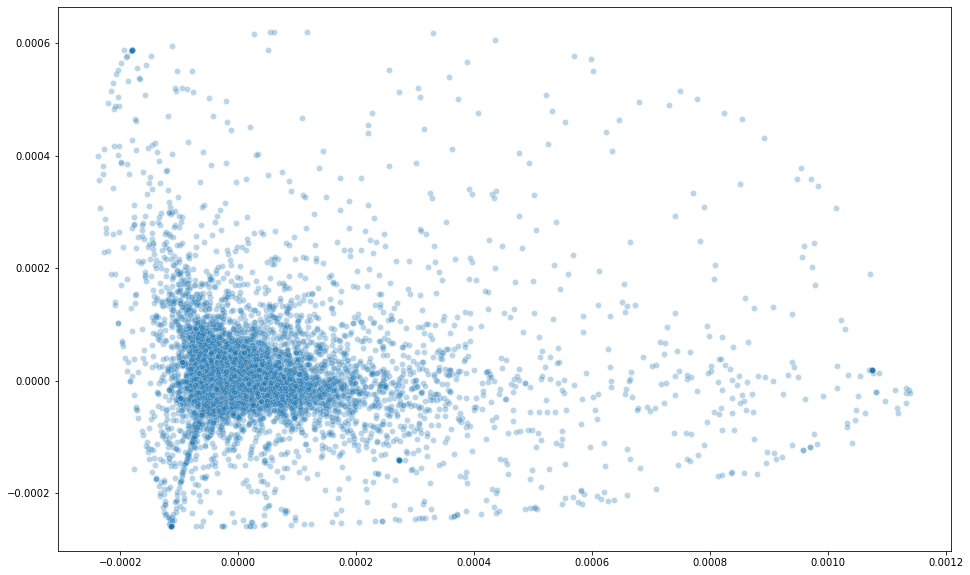

In [116]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageIII)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

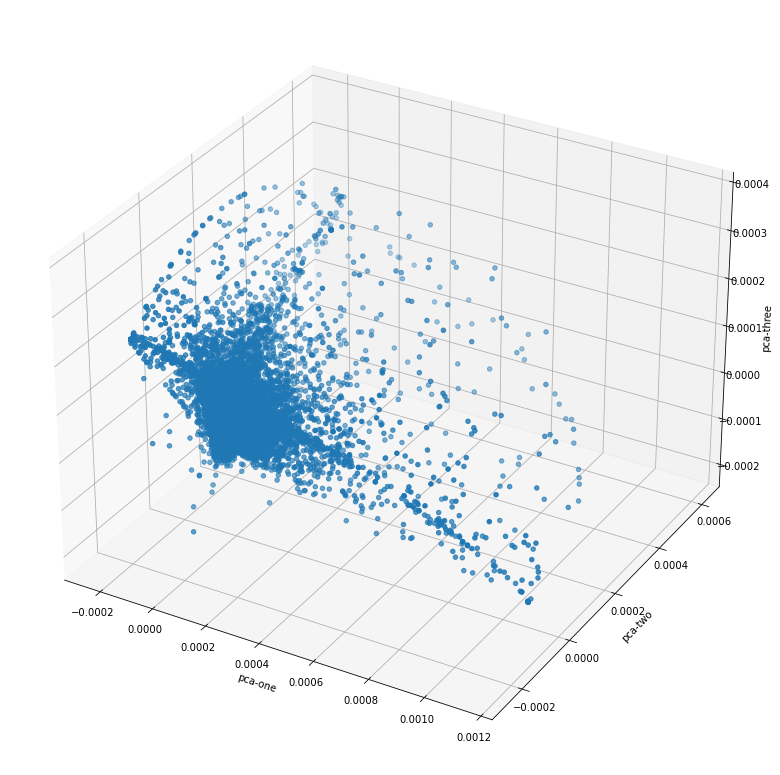

In [117]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Pathway embedding

### betweenness of genes in metapathways

In [11]:
import networkx as nx

In [12]:
geneEdges

source  target  weight
3        3640   59350       1
4      284217    3680       1
5      284217    3696       1
6      284217    3674       1
7      284217    3675       1
...       ...     ...     ...
28905    3627    1233       1
28906    3627    1232       1
28907    3627    2829       1
28908    3627   10663       1
28909    3627    2826       1

[19947 rows x 3 columns]

In [13]:
Gcontrols = nx.DiGraph()
Gtumors = nx.DiGraph()

for index, row in geneEdges.iterrows():
    Gcontrols.add_edge(row[0],row[1])
for index, row in geneEdgesTumor.iterrows():
    Gtumors.add_edge(row[0],row[1])

In [14]:
betweennessList = nx.betweenness_centrality(Gcontrols,normalized = True, 
                                              endpoints = False)

In [61]:
betweennessList

{3640: 0.0,
 59350: 0.0,
 284217: 0.0,
 3680: 8.759504308187752e-05,
 3696: 6.051496993954161e-05,
 3674: 0.002102842965792604,
 3675: 6.051496993954161e-05,
 3676: 0.00011497706112916001,
 3655: 6.051496993954161e-05,
 3678: 6.051496993954161e-05,
 3679: 6.051496993954161e-05,
 22987: 0.0,
 22801: 6.051496993954161e-05,
 3690: 0.015039451442100968,
 3691: 6.051496993954161e-05,
 3693: 6.051496993954161e-05,
 9899: 0.0,
 3694: 6.051496993954161e-05,
 3672: 6.051496993954161e-05,
 3695: 6.051496993954161e-05,
 3673: 0.0011639446572238566,
 960: 0.0,
 3685: 0.0018228265604341555,
 8516: 0.0002064441861024769,
 9900: 0.0,
 3688: 0.002517773947721919,
 8515: 6.051496993954161e-05,
 1605: 0.0,
 5747: 0.017309345336528236,
 2309: 0.009935009995445608,
 114907: 0.0,
 10370: 1.3985826105770238e-05,
 8698: 0.002824775794110961,
 1263: 0.0,
 2592: 0.0,
 9140: 9.650644895820814e-05,
 472: 0.0023680128394758747,
 595: 0.0004362682465122996,
 10733: 0.0,
 10018: 0.00031418272932976247,
 85417: 0.00

## Pathway embeddings for controls

In [37]:
tfDatasetGenesExpressions = tf.data.Dataset.from_tensor_slices((genesEmbeddings.index,genesEmbeddings.values))
normalizer_constant = genesEmbeddings.max().max()
normalizer_constant

0.01206990983337164

In [38]:
def printDS(dataset):
    for index,elem in dataset:
      print(elem.numpy())

listatest =  ['3915','79728','3293'] 
listatest = list(map(int, listatest))

keys_tensor = tf.constant(listatest,dtype=tf.int64)
vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0)  # If index not in table, return 0.


def hash_table_filter(index, value):
    table_value = table.lookup(index)  # 1 if index in arr, else 0.
    index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
    return index_in_arr

def filterdatasetOnIndex(ds):
    return ds.filter(hash_table_filter)

filtered = tfDatasetGenesExpressions.apply(filterdatasetOnIndex)
single = filtered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ len(listatest)
#single.numpy()

In [106]:
def gene_weight(geneIndex,dictBetw):
    if(geneIndex in dictBetw):
        return dictBetw[geneIndex] + 0.000001
    else:
        return 0.000001
gene_weight(3680,betweennessList)

8.859504308187752e-05

In [107]:
#geneWeights = tf.constant(list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index))),dtype=tf.float64)
geneWeights = list(map(lambda value: gene_weight(value,betweennessList),list(genesEmbeddings.index)))

In [108]:
type(geneWeights)

list

In [109]:
exprMatrixWeighted = genesEmbeddings.mul(geneWeights,axis=0)
exprMatrixWeighted

TCGA-E2-A1L7-11A-33R-A144-07  TCGA-BH-A0BC-11A-22R-A089-07  \
1                          8.809432e-09                  8.102904e-09   
2                          8.774232e-09                  8.106264e-09   
9                          8.810484e-09                  8.103892e-09   
10                         8.815434e-09                  8.284904e-09   
12                         8.810453e-09                  8.103866e-09   
...                                 ...                           ...   
100302401                  8.622337e-09                  8.470088e-09   
100302640                  8.770756e-09                  8.361213e-09   
100302692                  8.809294e-09                  8.102762e-09   
100302736                  8.831797e-09                  8.110267e-09   
100303728                  8.804806e-09                  8.095287e-09   

           TCGA-E9-A1N9-11A-71R-A14D-07  TCGA-BH-A18P-11A-43R-A12D-07  \
1                          9.434700e-09                  7.699947e-09   
2                          9.473373e-09                  7.618779e-09   
9                          9.436049e-09                  7.701614e-09   
10                         9.375855e-09                  7.529213e-09   
12                         9.436012e-09                  7.701568e-09   
...                                 ...                           ...   
100302401                  9.315452e-09                  7.489076e-09   
100302640                  9.399140e-09                  7.836565e-09   
100302692                  9.434508e-09                  7.699718e-09   
100302736                  9.447167e-09                  7.725020e-09   
100303728                  9.424881e-09                  7.690108e-09   

           TCGA-BH-A1FB-11A-33R-A13Q-07  TCGA-E9-A1RB-11A-33R-A157-07  \
1                          9.388806e-09                  1.014910e-08   
2                          9.658300e-09                  1.039955e-08   
9                          9.389559e-09                  1.015030e-08   
10                         9.406581e-09                  1.006560e-08   
12                         9.389543e-09                  1.015027e-08   
...                                 ...                           ...   
100302401                  9.211766e-09                  9.768131e-09   
100302640                  9.564560e-09                  1.014254e-08   
100302692                  9.388674e-09                  1.014892e-08   
100302736                  9.364160e-09                  1.014132e-08   
100303728                  9.375782e-09                  1.013588e-08   

           TCGA-BH-A1EO-11A-31R-A137-07  TCGA-GI-A2C8-11A-22R-A16F-07  \
1                          9.932111e-09                  8.103103e-09   
2                          9.956307e-09                  8.395692e-09   
9                          9.931155e-09                  8.101058e-09   
10                         9.791583e-09                  8.158307e-09   
12                         9.931183e-09                  8.101117e-09   
...                                 ...                           ...   
100302401                  9.880360e-09                  7.958668e-09   
100302640                  9.739166e-09                  8.028943e-09   
100302692                  9.932224e-09                  8.103369e-09   
100302736                  9.893351e-09                  8.053077e-09   
100303728                  9.931933e-09                  8.110547e-09   

           TCGA-E9-A1NA-11A-33R-A144-07  TCGA-BH-A0H9-11A-22R-A466-07  ...  \
1                          8.417797e-09                  9.884885e-09  ...   
2                          8.693527e-09                  1.005523e-08  ...   
9                          8.416626e-09                  9.883936e-09  ...   
10                         8.142524e-09                  9.766281e-09  ...   
12                         8.416660e-09                  9.883965e-09  ...   
...                                

In [110]:
tfExprMatrixWeighted = tf.data.Dataset.from_tensor_slices((exprMatrixWeighted.index,exprMatrixWeighted.values))

In [111]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfExprMatrixWeighted.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [112]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape)).dropna()

0      [6.510728211418858e-07, 6.014400673652883e-07,...
1      [7.272384567028605e-07, 6.734474246732263e-07,...
2      [6.443472682710792e-07, 5.989295514581342e-07,...
3      [0.0001461824224367481, 0.0001380670540722454,...
4      [9.477204943046556e-05, 8.989631905144604e-05,...
                             ...                        
222    [1.8660970684176654e-05, 1.769430469291317e-05...
223    [0.0008817795878548161, 0.0008364279852478395,...
224    [6.04498122736132e-07, 5.610775174899064e-07, ...
225    [7.289476701599625e-07, 6.755607286654356e-07,...
226    [0.00011106686445925174, 0.0001053343041999071...
Name: partialsVectors, Length: 226, dtype: object

In [113]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

In [114]:
sigmoid = lambda x: 1.0 / (1.0 + math.exp(-x))
vfunc = np.vectorize(sigmoid)
#vfunc(pathways["partialsVectors"][0])
# problemi con numeri grandi, il risultato finale sono vettori di tutti 1

In [115]:
def getPathwayEmbedding(partialVec,Wmat):
    partialvec_tensor = tf.constant(partialVec,dtype=tf.float64)
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = tf.linalg.matvec(W_tensor,partialvec_tensor)  #W_tensor @ partialvec_tensor
    finalVec = tf.map_fn(sigmoid,trasformedPartialVec)
    return finalVec


W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))
pathways["pathwayEmbeddings"]

0      (tf.Tensor(0.5000000001627682, shape=(), dtype...
1      (tf.Tensor(0.5000000001818097, shape=(), dtype...
2      (tf.Tensor(0.5000000001610868, shape=(), dtype...
3      (tf.Tensor(0.5000000365456057, shape=(), dtype...
4      (tf.Tensor(0.5000000236930123, shape=(), dtype...
                             ...                        
222    (tf.Tensor(0.5000000046652426, shape=(), dtype...
223    (tf.Tensor(0.5000002204448969, shape=(), dtype...
224    (tf.Tensor(0.5000000001511246, shape=(), dtype...
225    (tf.Tensor(0.5000000001822369, shape=(), dtype...
226    (tf.Tensor(0.5000000277667161, shape=(), dtype...
Name: pathwayEmbeddings, Length: 226, dtype: object

In [116]:
@tf.function
def sigmoid_log(x):
    return 1.0 / (1.0 + tf.math.exp(-tf.math.log(x)))

@tf.function( experimental_relax_shapes=True)
def getPathwayEmbeddingEnhancedFinal(partialsVec_tensor,Wmat):
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = W_tensor @ partialsVec_tensor
    finalVec = tf.map_fn(lambda values: tf.map_fn(tf.nn.leaky_relu,values),trasformedPartialVec)
    return finalVec

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [117]:
loss = tf.Variable(0.0,dtype="float64")

@tf.function( experimental_relax_shapes=True)
def getLoss(pathwaysEmbeddingTensor,loss):
    for zPi in pathwaysEmbeddingTensor:
        #print(zPi.get_shape())
        for zPj in pathwaysEmbeddingTensor:
            loss = loss + tf.sqrt(tf.reduce_sum(tf.square(zPi - zPj)) + 1.0e-12)   #tf.norm is unstable
    return loss

firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()

In [118]:
firstLoss

0.6738846968097691

In [124]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = 1.0 / getLoss(tf.transpose(finalVectors_tensors),loss)


In [125]:
dl_dw = tape.gradient(loss, W)
dl_dw

<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[-0.12489228, -0.11848381, -0.13605238, ..., -0.12144788,
        -0.13859804, -0.14510148],
       [-0.11848381, -0.11240426, -0.12907135, ..., -0.1152162 ,
        -0.13148632, -0.13765612],
       [-0.13605238, -0.12907135, -0.14820984, ..., -0.13230024,
        -0.15098288, -0.15806751],
       ...,
       [-0.12144788, -0.1152162 , -0.13230024, ..., -0.11809853,
        -0.13477566, -0.14109978],
       [-0.13859804, -0.13148632, -0.15098288, ..., -0.13477566,
        -0.15380793, -0.16102502],
       [-0.14510148, -0.13765612, -0.15806751, ..., -0.14109978,
        -0.16102502, -0.16858093]])>

In [126]:
learning_rate = 0.0001
loss_progression = np.array([firstLoss])

for i in range(0,10):
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss_progression = np.append(loss_progression,1.0/getLoss(tf.transpose(finalVectors_tensors),loss).numpy())

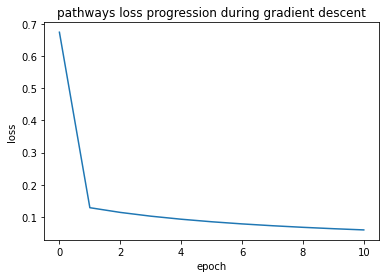

In [127]:
x = np.arange(0,11)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [128]:
loss_progression

array([0.6738847 , 0.12878699, 0.11413228, 0.1024718 , 0.09297297,
       0.0850857 , 0.07843196, 0.07274336, 0.06782411, 0.06352802,
       0.05974375])

In [129]:
loss = tf.Variable(0.0,dtype="float64")
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
getLoss(tf.transpose(finalVectors_tensors),loss)

<tf.Tensor: shape=(), dtype=float64, numpy=16.587018655396218>

In [130]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

In [131]:
pathways

pathway_id                                  pathway_name  \
0    path:hsa00190                     Oxidative phosphorylation   
1    path:hsa00072    Synthesis and degradation of ketone bodies   
2    path:hsa01040       Biosynthesis of unsaturated fatty acids   
3    path:hsa04672  Intestinal immune network for IgA production   
4    path:hsa03460                        Fanconi anemia pathway   
..             ...                                           ...   
222  path:hsa03013                                 RNA transport   
223  path:hsa04340                    Hedgehog signaling pathway   
224  path:hsa03018                               RNA degradation   
225  path:hsa00785                        Lipoic acid metabolism   
226  path:hsa03015                     mRNA surveillance pathway   

                                                 nodes  \
0    64077;5464;245972;245973;479;513;514;515;516;5...   
1      64064;38;39;3155;56898;54511;622;3158;3157;5019   
2    641371;79966;6319;570;9415;3992;10965;122970;1...   
3    4055;8174;959;8741;3600;23308;102723407;6370;5...   
4    3280;378708;55120;672;84126;675;2189;83990;229...   
..                                                 ...   
222  8893;8891;8892;9984;8890;1975;340529;8662;8663...   
223  64399;122011;595;1456;1455;1454;1453;1452;6469...   
224  5042;132430;340529;8761;645974;26986;80336;992...   
225                          116285;11019;387787;51601   
226  81608;23049;2107;10898;10978;53981;4686;5976;5...   

                                       partialsVectors  \
0    [6.510728211418858e-07, 6.014400673652883e-07,...   
1    [7.272384567028605e-07, 6.734474246732263e-07,...   
2    [6.443472682710792e-07, 5.989295514581342e-07,...   
3    [0.0001461824224367481, 0.0001380670540722454,...   
4    [9.477204943046556e-05, 8.989631905144604e-05,...   
..                                                 ...   
222  [1.8660970684176654e-05, 1.769430469291317e-05...   
223  [0.0008817795878548161, 0.0008364279852478395,...   
224  [6.04498122736132e-07, 5.610775174899064e-07, ...   
225  [7.289476701599625e-07, 6.755607286654356e-07,...   
226  [0.00011106686445925174, 0.0001053343041999071...   

                                     pathwayEmbeddings  
0    [6.510728211418859e-10, 6.014400673652883e-10,...  
1    [7.272384567028605e-10, 6.734474246732263e-10,...  
2    [6.443472682710792e-10, 5.989295514581342e-10,...  
3    [1.4618242243674808e-07, 1.380670540722454e-07...  
4    [9.477204943046556e-08, 8.989631905144603e-08,...  
..                                                 ...  
222  [1.8660970684176653e-08, 1.769430469291317e-08...  
223  [8.817795878548162e-07, 8.364279852478395e-07,...  
224  [6.04498122736132e-10, 5.610775174899064e-10, ...  
225  [7.289476701599626e-10, 6.755607286654356e-10,...  
226  [1.1106686445925174e-07, 1.0533430419990719e-0...  

[226 rows x 5 columns]

In [132]:
pathways["pathway_name"].describe()

count                       226
unique                      226
top       Tryptophan metabolism
freq                          1
Name: pathway_name, dtype: object

In [133]:
pathways["pathwayEmbeddings"][29]

[5.464396147767968e-10,
 5.042605384334697e-10,
 5.857122263505764e-10,
 4.779154940170758e-10,
 5.853818532099657e-10,
 6.326952983367936e-10,
 6.175852241753395e-10,
 5.056822000395525e-10,
 5.263720337790984e-10,
 6.15833223186448e-10,
 4.963930102021093e-10,
 5.050732092913508e-10,
 5.061161758745219e-10,
 5.579731317988695e-10,
 6.383094137122417e-10,
 5.400750393500231e-10,
 5.172566556303731e-10,
 5.156405973101628e-10,
 5.045405931589177e-10,
 5.019481482861801e-10,
 6.158019055912719e-10,
 5.389239561721107e-10,
 5.2416809780457e-10,
 5.343449321668797e-10,
 6.222397450934866e-10,
 6.160597910858877e-10,
 5.651125886354494e-10,
 4.4537554329806547e-10,
 4.479633271828546e-10,
 4.959037704339834e-10,
 6.391635005706418e-10,
 6.199412149351923e-10,
 6.171974097233427e-10,
 4.629512342701181e-10,
 4.5299754139034465e-10,
 6.005306861506669e-10,
 4.767190065954643e-10,
 4.830094498890313e-10,
 4.901725830011759e-10,
 4.917955423806249e-10,
 4.560289172611319e-10,
 4.93380509765186

In [134]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [135]:
onlyPathwayEmbeddings

0             1             2             3             4    \
0    6.510728e-10  6.014401e-10  6.983015e-10  5.684255e-10  7.005886e-10   
1    7.272385e-10  6.734474e-10  7.803569e-10  6.371559e-10  7.826629e-10   
2    6.443473e-10  5.989296e-10  6.932226e-10  5.657495e-10  6.986995e-10   
3    1.461824e-07  1.380671e-07  1.590559e-07  1.287619e-07  1.662171e-07   
4    9.477205e-08  8.989632e-08  1.031532e-07  8.362322e-08  1.081923e-07   
..            ...           ...           ...           ...           ...   
221  1.866097e-08  1.769430e-08  2.029018e-08  1.646269e-08  2.126797e-08   
222  8.817796e-07  8.364280e-07  9.602410e-07  7.789260e-07  1.008633e-06   
223  6.044981e-10  5.610775e-10  6.490455e-10  5.295622e-10  6.585731e-10   
224  7.289477e-10  6.755607e-10  7.852105e-10  6.573843e-10  7.768408e-10   
225  1.110669e-07  1.053343e-07  1.210067e-07  9.798601e-08  1.269906e-07   

              5             6             7             8             9    \
0    7.570068e-10  7.358279e-10  6.050901e-10  6.293688e-10  7.355043e-10   
1    8.423159e-10  8.220910e-10  6.748812e-10  6.993229e-10  8.212922e-10   
2    7.507766e-10  7.327351e-10  6.019414e-10  6.266049e-10  7.329669e-10   
3    1.774796e-07  1.699429e-07  1.431162e-07  1.500552e-07  1.724175e-07   
4    1.152360e-07  1.106428e-07  9.301997e-08  9.769747e-08  1.122398e-07   
..            ...           ...           ...           ...           ...   
221  2.269140e-08  2.179112e-08  1.827890e-08  1.922358e-08  2.208702e-08   
222  1.072611e-06  1.030595e-06  8.668781e-07  9.102360e-07  1.045320e-06   
223  7.097764e-10  6.886745e-10  5.686845e-10  5.943739e-10  6.907700e-10   
224  8.428983e-10  8.163430e-10  6.643903e-10  7.024334e-10  8.203184e-10   
225  1.352056e-07  1.297358e-07  1.092201e-07  1.146117e-07  1.316156e-07   

     ...           103           104           105           106  \
0    ...  7.369633e-10  7.328857e-10  7.324230e-10  7.404127e-10   
1    ...  8.236998e-10  8.209904e-10  8.193984e-10  8.259729e-10   
2    ...  7.319102e-10  7.261979e-10  7.319485e-10  7.394821e-10   
3    ...  1.676322e-07  1.673801e-07  1.681512e-07  1.761690e-07   
4    ...  1.088172e-07  1.086291e-07  1.093650e-07  1.147642e-07   
..   ...           ...           ...           ...           ...   
221  ...  2.141799e-08  2.138894e-08  2.152350e-08  2.257207e-08   
222  ...  1.012757e-06  1.011526e-06  1.018458e-06  1.069564e-06   
223  ...  6.863943e-10  6.809843e-10  6.856520e-10  6.974472e-10   
224  ...  8.210931e-10  8.201321e-10  8.203727e-10  8.182092e-10   
225  ...  1.274328e-07  1.273636e-07  1.282256e-07  1.347127e-07   

              107           108           109           110           111  \
0    6.083978e-10  5.574982e-10  6.263172e-10  6.136633e-10  7.108924e-10   
1    6.799993e-10  6.253259e-10  7.028108e-10  6.854841e-10  7.952972e-10   
2    6.053840e-10  5.539057e-10  6.237985e-10  6.115350e-10  7.065593e-10   
3    1.393607e-07  1.236547e-07  1.437500e-07  1.416767e-07  1.616486e-07   
4    9.056031e-08  8.037392e-08  9.328990e-08  9.211520e-08  1.051172e-07   
..            ...           ...           ...           ...           ...   
221  1.779331e-08  1.582983e-08  1.836884e-08  1.810609e-08  2.071169e-08   
222  8.427259e-07  7.468694e-07  8.682848e-07  8.576525e-07  9.787210e-07   
223  5.685263e-10  5.186633e-10  5.845699e-10  5.744931e-10  6.616046e-10   
224  6.855801e-10  6.271170e-10  7.080432e-10  6.808343e-10  7.862002e-10   
225  1.060468e-07  9.403350e-08  1.092720e-07  1.078836e-07  1.233332e-07   

              112  
0    7.330683e-10  
1    8.170281e-10  
2    7.280613e-10  
3    1.693299e-07  
4    1.100393e-07  
..            ...  
221  2.168515e-08  
222  1.023543e-06  
223  6.864598e-10  
224  8.124151e-10  
225  1.289883e-07  

[226 rows x 113 columns]

In [136]:
onlyPathwayEmbeddings.describe()

0             1             2             3             4    \
count  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02   
mean   9.385276e-07  8.903184e-07  1.022314e-06  8.284458e-07  1.073627e-06   
std    1.117693e-06  1.060388e-06  1.217633e-06  9.865791e-07  1.278915e-06   
min    2.430750e-10  2.281357e-10  2.552218e-10  2.213629e-10  2.652295e-10   
25%    7.049494e-10  6.514174e-10  7.554826e-10  6.172186e-10  7.571914e-10   
50%    2.461499e-07  2.332505e-07  2.678802e-07  2.172293e-07  2.807120e-07   
75%    1.788241e-06  1.696134e-06  1.947740e-06  1.578710e-06  2.045115e-06   
max    4.665739e-06  4.428076e-06  5.084491e-06  4.118442e-06  5.343235e-06   

                5             6             7             8             9    \
count  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02   
mean   1.142992e-06  1.096964e-06  9.227885e-07  9.694167e-07  1.112869e-06   
std    1.361605e-06  1.306628e-06  1.099247e-06  1.154871e-06  1.325638e-06   
min    2.798051e-10  2.655055e-10  2.202416e-10  2.372281e-10  2.745904e-10   
25%    8.160103e-10  7.966733e-10  6.531638e-10  6.780299e-10  7.953506e-10   
50%    2.984971e-07  2.868683e-07  2.412120e-07  2.528806e-07  2.908860e-07   
75%    2.177165e-06  2.089377e-06  1.757800e-06  1.846505e-06  2.119724e-06   
max    5.687766e-06  5.459331e-06  4.592873e-06  4.824525e-06  5.536835e-06   

       ...           103           104           105           106  \
count  ...  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02   
mean   ...  1.077939e-06  1.076820e-06  1.083615e-06  1.138434e-06   
std    ...  1.283821e-06  1.282479e-06  1.290652e-06  1.356118e-06   
min    ...  2.730540e-10  2.802502e-10  2.687353e-10  2.690595e-10   
25%    ...  7.976563e-10  7.929175e-10  7.954149e-10  8.002664e-10   
50%    ...  2.824197e-07  2.823170e-07  2.836995e-07  2.975031e-07   
75%    ...  2.053579e-06  2.051947e-06  2.064011e-06  2.168683e-06   
max    ...  5.360490e-06  5.354037e-06  5.390831e-06  5.664374e-06   

                107           108           109           110           111  \
count  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02  2.260000e+02   
mean   8.966199e-07  7.948337e-07  9.242497e-07  9.125888e-07  1.041503e-06   
std    1.067851e-06  9.465377e-07  1.100671e-06  1.086911e-06  1.240369e-06   
min    2.227275e-10  2.116951e-10  2.426190e-10  2.145943e-10  2.629331e-10   
25%    6.583346e-10  6.059991e-10  6.799435e-10  6.645168e-10  7.691618e-10   
50%    2.350039e-07  2.085349e-07  2.425056e-07  2.390326e-07  2.729730e-07   
75%    1.708258e-06  1.514083e-06  1.761350e-06  1.738568e-06  1.984553e-06   
max    4.459074e-06  3.954749e-06  4.596116e-06  4.540016e-06  5.180519e-06   

                112  
count  2.260000e+02  
mean   1.090296e-06  
std    1.298622e-06  
min    2.694893e-10  
25%    7.917425e-10  
50%    2.852864e-07  
75%    2.076953e-06  
max    5.424224e-06  

[8 rows x 113 columns]

<AxesSubplot:>

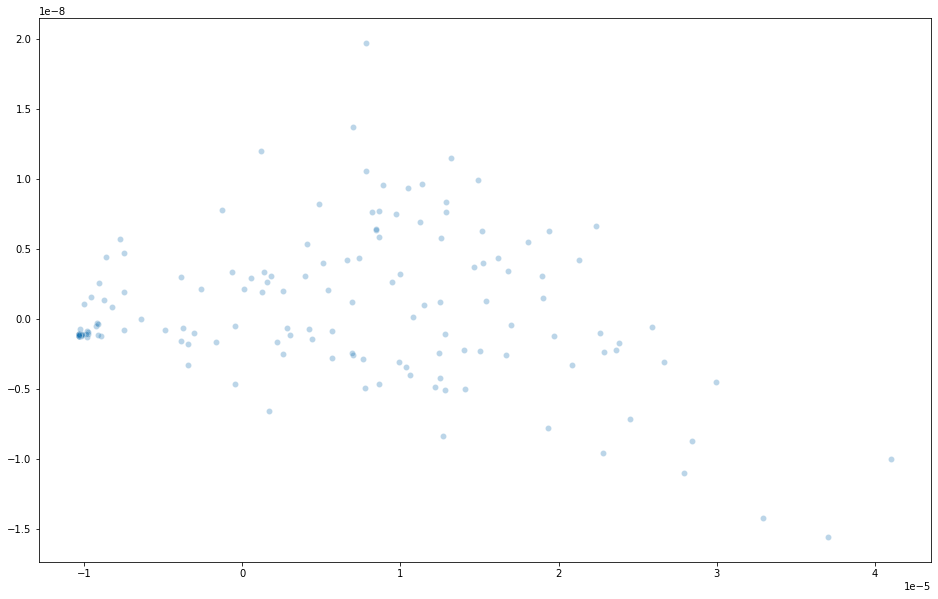

In [137]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

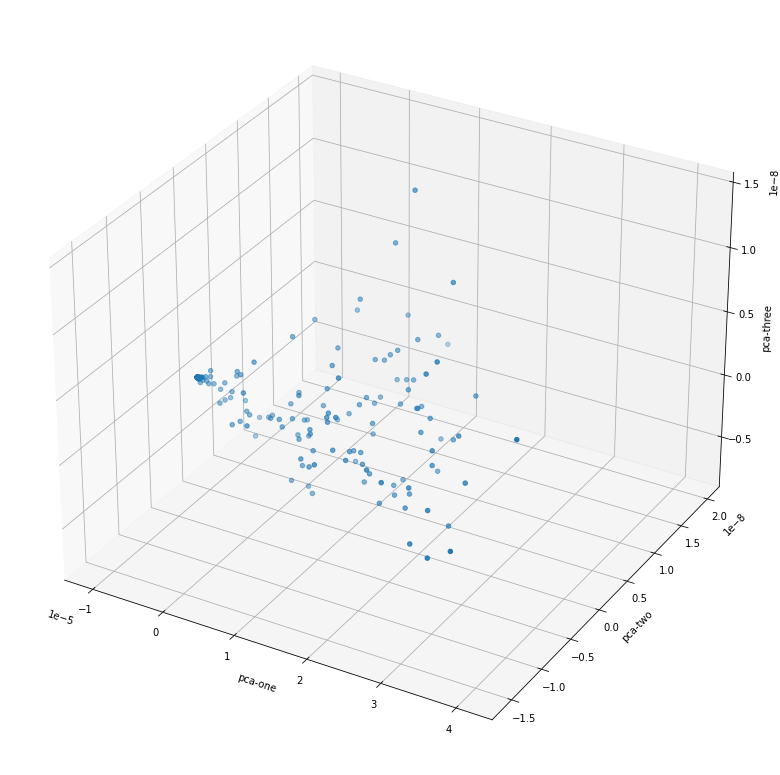

In [138]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()